In [1]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm

from itertools import permutations
import sys

import numpy as np

import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore')

In [2]:
"""
This file contains code for conditional entropy forests. 
Adapted from https://github.com/rguo123/conditional_entropy_forests/blob/master/code/algorithm.py
"""

def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R

def generate_3d_rotation(acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    q = np.random.normal(0,1,4)
    q = q / np.sqrt(np.sum(q**2))
    
    R = np.array([
        [1 -2*(q[2]**2+q[3]**2), 2*(q[1]*q[2]-q[3]*q[0]), 2*(q[1]*q[3]+q[2]*q[0])],
        [2*(q[1]*q[2]+q[3]*q[0]), 1-2*(q[1]**2+q[3]**2), 2*(q[2]*q[3]-q[1]*q[0])],
        [2*(q[1]*q[3] - q[2]*q[0]), 2*(q[2]*q[3]+q[1]*q[0]), 1-2*(q[1]**2+q[2]**2)]
    ])
    return R

def finite_sample_correction(class_probs, row_sums):
    
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
    where_1 = np.argwhere(class_probs == 1)
    for elem in where_1:
        class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
    
    return class_probs

def build_model(X, y, n_estimators=200, max_samples=.32,
                                            bootstrap=True,
                                            depth=30,
                                            min_samples_leaf=1):
    if X.ndim == 1:
        raise ValueError('1d data will cause headaches down the road')
        
    max_features = int(np.ceil(np.sqrt(X.shape[1])))
        
    model=BaggingClassifier(DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples_leaf,
                                                     max_features = max_features),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              bootstrap=bootstrap)
    
    model.fit(X, y)
    return model

def get_leaves(estimator):
    # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    
    leaf_ids = []
    stack = [(0, -1)] 
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_ids.append(node_id)
            
    return np.array(leaf_ids)

def estimate_posteriors(model, train, y, test, in_task=True, subsample=0, acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    n, d = train.shape
    m, d_ = test.shape
    
    if d != d_:
        raise ValueError("train and test data in different dimensions")
    
    class_counts = np.zeros((m, model.n_classes_))
    for tree in model:
        # get out of bag indicies
        if in_task:
            prob_indices = _generate_unsampled_indices(tree.random_state, n)
            # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
        else:
            if subsample:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)
            else:
                prob_indices = range(n)
        
        leaf_nodes = get_leaves(tree)
        unique_leaf_nodes = np.unique(leaf_nodes)
            
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(unique_leaf_nodes), model.n_classes_))

        for prob_index in prob_indices:
            temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
            posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1
            
        # total number of points in a node
        row_sums = posterior_class_counts.sum(axis=1)
        
        # no divide by zero
        row_sums[row_sums == 0] = 1

        # posteriors
        class_probs = (posterior_class_counts / row_sums[:, None])
        # posteriors with finite sampling correction
        
        class_probs = finite_sample_correction(class_probs, row_sums)
    
        # posteriors as a list
        class_probs.tolist()
        
        partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts / class_counts.sum(axis=1, keepdims=True)
    
    return probs

def predict(a):
    return np.argmax(a, axis = 1)

def permutation(predict1, predict2, force=False):
    """
    how to use:
    
    this function returns the permutation i.e. \pi: [K] -> [K] that maximizes
    the number of matched predictions
    
    to use the permutation for posteriors for point i (posterior_i), say, simply use
    posterior_i[permutation]
    
    """
    unique_1 = np.unique(predict1)
    unique_1_new = np.arange(len(unique_1))
    
    unique_2 = np.unique(predict2)
    unique_2_new = np.arange(len(unique_2))
    
    if force:
        for i, u in enumerate(unique_1_new):
            if u not in unique_2_new:
                unique_2_new = np.concatenate((unique_2_new, [u]))
        
        for i, u in enumerate(unique_2_new):
            if u not in unique_1_new:
                unique_1_new = np.concatenate((unique_1_new, [u]))
    else:
        if set(unique_1) != set(unique_2):
            raise ValueError("predictions must be on the same set of labels")
        
    K = len(unique_1_new)
    
    max_sum = 0
    max_perm = unique_2_new
    for i, perm in enumerate(permutations(unique_2_new)):
        perm = np.array(list(perm))
        temp_predict2 = -1*np.ones(len(predict2))
        
        for k in range(K):
            temp_predict2[np.where(predict2 == unique_2_new[k])[0]] = perm[k]
           
        temp_sum = np.sum(predict1 == temp_predict2)
        if temp_sum > max_sum:
            max_sum = temp_sum
            max_perm = perm
            
    return max_perm
            
def estimate_alpha(predict1, predict2, permutation=None):
    if permutation is None:
        return 2* (np.sum(predict1 == predict2) / len(predict1) - 0.5)
    else:
        unique = np.unique(predict2)
        unique_temp = np.unique(predict1)
        if len(unique) != len(unique_temp):
            unique = np.concatenate((unique, range(len(unique), len(unique) + len(unique_temp) - len(unique_temp))))
        temp_predict2 = -1*np.ones(len(predict2))
        
        for i, k in enumerate(unique):
            print(np.where(predict2 == k)[0])
            print(permutation[i])
            temp_predict2[np.where(predict2 == k)[0]] = permutation[i]
            
        return 2 * (np.sum(predict1 == temp_predict2) / len(predict1) - 0.5)
    
def generate_sample(n, pi, conditional_0, params0, conditional_1, params1, d = 2, acorn=None):
    if acorn is None:
        acorn = np.random.seed(10**6)
    np.random.seed(acorn)
    
    n0 = int(np.random.binomial(n, pi))
    n1 = n - n0
    ns = [n0, n1]
    
    X0 = conditional_0(*params0, size=(n0, d))
    
    X1 = conditional_1(*params1, size=(n1, d))
    
    labels = np.concatenate([i*np.ones(ns[i]) for i in range(len(ns))]).astype(int)
    
    return [np.concatenate((X0, X1), axis = 0), labels]

def generate_parity(n, d=2, invert_labels=False,acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    X = np.random.uniform(-1, 1, size=(n, d))
    Y = (np.sum(X > 0, axis=1) % 2 == 0).astype(int)
    
    if invert_labels:
        Y = -1 * (Y - 1)
    
    return X, Y.astype(int)

def parity_experiment(nx, nz, d, m, n_algos=6):
    Tx = int(np.floor(np.sqrt(nx)))
    Tz = int(np.floor(np.sqrt(nz)))
    
    Kx = int(np.floor(np.log(nx)))
    Kz = int(np.floor(np.log(nz)))
    
    errors = np.zeros(n_algos)
    
    temp_predictions = [[] for __ in range(n_algos)]
    
    # Sum
    Z, labelsZ = generate_parity(nz + nx, d, invert_labels=True)
    testZ, test_labelsZ = generate_parity(m, d, invert_labels=True)
    
    model_best = build_model(Z, labelsZ, int(np.floor(np.sqrt(nx + nz))))
    
    posteriors_best=estimate_posteriors(model_best, Z, labelsZ, testZ, in_task=True)
    predictions_best=predict(posteriors_best)
    
    errors[-1] = 1 - np.sum(test_labelsZ == predictions_best)/m

    # Source task
    X, labelsX = generate_parity(nx, d)
    testX, test_labelsX = generate_parity(m, d)

    
    # Target task
    Z, labelsZ = generate_parity(nz, d, invert_labels=True)
    testZ, test_labelsZ = generate_parity(m, d, invert_labels=True)


    model_X = build_model(X, labelsX, Tx)
    model_Z = build_model(Z, labelsZ, Tz)

    posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, testX, in_task=True)
    posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, testX, in_task=False, subsample=1-0.32)

    pred_structX_estX=predict(posteriors_structX_estX)
    pred_structZ_estX=predict(posteriors_structZ_estX)

    posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, testZ, in_task=False, subsample=1-0.32)
    posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, testZ, in_task=True)
    
    pred_structX_estZ=predict(posteriors_structX_estZ)
    pred_structZ_estZ=predict(posteriors_structZ_estZ)

    # calculate errors without attempting to transfer knowledge
    pred_X = predict(posteriors_structX_estX)
    pred_Z = predict(posteriors_structZ_estZ)

    # 
    errors[0] = 1 - np.sum(test_labelsX == pred_X)/m
    errors[1] = 1 - np.sum(test_labelsZ == pred_Z)/m
    
    errors[2] = 1 - np.sum(test_labelsX == pred_structZ_estX)/m
    errors[3] = 1 - np.sum(test_labelsZ == pred_structX_estZ)/m
    
    

    # jtv ?
    pred_X_jtv = predict(posteriors_structX_estX + posteriors_structZ_estX)
    pred_Z_jtv = predict(posteriors_structZ_estZ + posteriors_structX_estZ)

    errors[4] = 1 - np.sum(test_labelsX == pred_X_jtv)/m
    errors[5] = 1 - np.sum(test_labelsZ == pred_Z_jtv)/m
    
    # now using local estimates..
#     new_posteriors_structX_estZ_local = np.zeros(posteriors_structX_estZ.shape)
#     new_posteriors_structZ_estX_local = np.zeros(posteriors_structZ_estX.shape)

#     kNN_X = NearestNeighbors(n_neighbors=Kx).fit(testX)    
#     kNN_Z = NearestNeighbors(n_neighbors=Kz).fit(testZ)

#     alpha_X_local = np.zeros(m)
#     for k, obs in enumerate(testX):
#         obs = obs.reshape(1, -1)
#         temp_neighbors = kNN_X.kneighbors(obs)[1]

#         temp_preds_structX_estX = pred_structX_estX[temp_neighbors]
#         temp_preds_structZ_estX = pred_structZ_estX[temp_neighbors]

#         temp_permutation = permutation(temp_preds_structX_estX, temp_preds_structZ_estX, force=True)

#         pred_structZ_estX_local = predict(new_posteriors_structZ_estX_local)

#         alpha_X_local[k] = estimate_alpha(pred_structZ_estX_local, pred_structX_estX)
#         new_posteriors_structZ_estX_local[k] = alpha_X_local[k]*posteriors_structZ_estX[k][temp_permutation]

#     alpha_Z_local = np.zeros(m)
#     for k, obs in enumerate(testZ):
#         obs = obs.reshape(1, -1)
#         temp_neighbors = kNN_Z.kneighbors(obs)[1]

#         temp_preds_structX_estZ = pred_structX_estZ[temp_neighbors]
#         temp_preds_structZ_estZ = pred_structZ_estZ[temp_neighbors]

#         temp_permutation = permutation(temp_preds_structX_estZ, temp_preds_structZ_estZ, force=True)
#         pred_structX_estZ_local = predict(new_posteriors_structX_estZ_local)

#         alpha_Z_local[k] = estimate_alpha(pred_structZ_estZ, pred_structX_estZ_local)
#         new_posteriors_structX_estZ_local[k] = alpha_Z_local[k]*posteriors_structX_estZ[k][temp_permutation]

#     pred_X_cep_local = predict(posteriors_structX_estX +  new_posteriors_structZ_estX_local)
#     pred_Z_cep_local = predict(posteriors_structZ_estZ + new_posteriors_structX_estZ_local)

    
#     print("X:" + str(pred_X_cep_local))
#     errors[6] = 1 - np.sum(test_labelsX == pred_X_cep_local)/m
#     print("Z:" + str(pred_Z_cep_local))
#     errors[7] = 1 - np.sum(test_labelsZ == pred_Z_cep_local)/m

    return errors

In [3]:
def jovo_experiment(nx, nz, d, dist_x=generate_parity, dist_z=generate_parity, theta=0, m=100, target="Z", subsample = 0.32, n_algos=6):
    if target == "Z":
        invert_z = True
        invert_x = False
    else:
        invert_z = False
        invert_x = True
        
    Tx = int(np.floor(np.sqrt(nx)))
    Tz = int(np.floor(np.sqrt(nz)))
    
    Kx = int(np.floor(np.log(nx)))
    Kz = int(np.floor(np.log(nz)))
    
    errors = np.zeros(n_algos)

    # Source task
    X, labelsX = dist_x(nx, d, invert_labels=invert_x)
    testX, test_labelsX = dist_x(m, d, invert_labels=invert_x)

    
    # Target task
    Z, labelsZ = dist_z(nz, d, invert_labels=invert_z)
    testZ, test_labelsZ = dist_z(m, d, invert_labels=invert_z)
    
    if len(X[0, :]) == 2:
        R = generate_2d_rotation(theta)
    else:
        R = generate_3d_rotation()
        
    Z = Z @ R
    testZ = testZ @ R

    model_X = build_model(X, labelsX, Tx)
    model_Z = build_model(Z, labelsZ, Tz)

    posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, testX, in_task=True)
    posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, testX, in_task=False, subsample=subsample)

    pred_structX_estX=predict(posteriors_structX_estX)
    pred_structZ_estX=predict(posteriors_structZ_estX)

    posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, testZ, in_task=False, subsample=subsample)
    posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, testZ, in_task=True)
    
    pred_structX_estZ=predict(posteriors_structX_estZ)
    pred_structZ_estZ=predict(posteriors_structZ_estZ)

    # calculate errors without attempting to transfer knowledge
    pred_X = predict(posteriors_structX_estX)
    pred_Z = predict(posteriors_structZ_estZ)

    errors[0] = 1 - np.sum(test_labelsX == pred_X)/m
    errors[3] = 1 - np.sum(test_labelsZ == pred_Z)/m
    
    errors[1] = 1 - np.sum(test_labelsX == pred_structZ_estX)/m
    errors[4] = 1 - np.sum(test_labelsZ == pred_structX_estZ)/m

    # jtv ?
    pred_X_jtv = predict(posteriors_structX_estX + posteriors_structZ_estX)
    pred_Z_jtv = predict(posteriors_structZ_estZ + posteriors_structX_estZ)

    errors[2] = 1 - np.sum(test_labelsX == pred_X_jtv)/m
    errors[5] = 1 - np.sum(test_labelsZ == pred_Z_jtv)/m
    
    # Sum
#     X, labelsX = dist_x(nz + nx, d, invert_labels=invert_x)
#     testX, test_labelsX = dist_x(m, d, invert_labels=invert_x)
    
#     model_best_X = build_model(X, labelsX, int(np.floor(np.sqrt(nx + nz))))
    
#     posteriors_best_X=estimate_posteriors(model_best_X, X, labelsX, testX, in_task=True)
#     predictions_best_X=predict(posteriors_best_X)
    
#     errors[2] = 1 - np.sum(test_labelsX == predictions_best_X)/m
    
    # Sum
#     Z, labelsZ = dist_z(nz + nx, d, invert_labels=invert_z)
#     Z = Z @ R
#     testZ, test_labelsZ = dist_z(m, d, invert_labels=invert_z)
    
#     model_best_Z = build_model(Z, labelsZ, int(np.floor(np.sqrt(nx + nz))))
    
#     posteriors_best_Z=estimate_posteriors(model_best_Z, Z, labelsZ, testZ, in_task=True)
#     predictions_best_Z=predict(posteriors_best_Z)
    
#     errors[5] = 1 - np.sum(test_labelsZ == predictions_best_Z)/m

    return errors

In [4]:
np.random.seed(3)
X, labelsX = generate_parity(500, 2)
temp_labelsX = []
# testX, test_labelsX = generate_parity(m, d)
    
# Target task
Z, labelsZ = generate_parity(650, 2, invert_labels=True)
Z = Z @ generate_2d_rotation(theta=0)
# temp_idx = (abs(Z[:, 0]) < 1).astype(int) + (abs(Z[:, 1])  < 1).astype(int)  == 2
# Z = Z[temp_idx]
temp_labelsZ = []
# testZ, test_labelsZ = generate_parity(m, d, invert_labels=True)

for i in range(len(labelsX)):
    if labelsX[i] == 0:
        temp_labelsX.append('k')
    else:
        temp_labelsX.append('pink')
       
for i in range(len(labelsZ)):
    if labelsZ[i] == 0:
        temp_labelsZ.append('k')
    else:
        temp_labelsZ.append('pink')

Text(0.5, 1.0, 'not_parity')

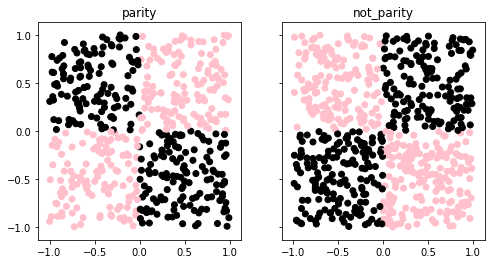

In [6]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize = (8,4))
ax[0].scatter(X[:, 0], X[:, 1], c = temp_labelsX)
ax[1].scatter(Z[:, 0], Z[:, 1], c = temp_labelsZ)
ax[0].set_title('parity')
ax[1].set_title('not_parity')
# plt.savefig('parity_not_parity_plots.png')

In [7]:
from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

mc_its = 50 # number of simulation repititions
# ns0 = (10*np.arange(3,5,step=1)).astype(int)
ns = (100*np.arange(0.5, 4.5, step=0.5)).astype(int) # number of training samples 
nz_prop = 1

m = 100 # number of test samples each monte carlo iteration

algorithms = ['Decision Forest Parity', 'Decision Forest Not-Parity', 'Lifelong Forests']
algorithms = np.concatenate((algorithms, ['Decision Forest Not-Parity', 'Decision Forest Parity', 'Lifelong Forests']))

M = len(algorithms)

In [8]:
mean_error = np.zeros((M, len(ns)))
std_error = np.zeros((M, len(ns)))

d = 2
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : jovo_experiment(100, x, d, theta=np.pi, m=m, n_algos=M)
    
    errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
    
    mean_error[:, j] = np.mean(errors, axis=0)
    std_error[:, j] = np.std(errors, ddof=1, axis=0)

100%|██████████| 8/8 [00:15<00:00,  2.07s/it]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

mc_it = 100

sns.set()
colors = sns.color_palette("Set1", n_colors = M)
fig1, ax = plt.subplots(2,2, figsize = (12, 6), sharex = 'row', sharey='row')

# fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize = (8,4))
ax[0,0].scatter(X[:, 0], X[:, 1], c = temp_labelsX)
ax[0,1].scatter(Z[:, 0], Z[:, 1], c = np.array(temp_labelsZ))


ax[0,0].set_title('Source Task: Parity')
ax[0,1].set_title('Target Task: Rotated Parity')
    
algo_offset=0
for i, algo in enumerate(algorithms[algo_offset:-3]):
    ax[1,0].plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i])
    ax[1,0].fill_between(ns, 
            mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
    
algo_offset=3
for i, algo in enumerate(algorithms[algo_offset:]):
    ax[1,1].plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i + algo_offset])
    ax[1,1].fill_between(ns, 
            mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i +algo_offset], 
            alpha=0.15,
            interpolate=True)
ax[1,0].legend(loc='upper center')
ax[1,1].legend(loc='upper center')
ax[1,0].set_xlabel('Target Task Sample Size')
ax[1,0].set_ylabel('Misclassification Rate')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])

ax[1,1].set_xlabel('Target Task Sample Size')
# ax[1].set_ylabel('L_hat')data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAgUAAAESCAYAAABtp6azAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzs3Xd4FFXbB+DfzOymb3ohdEINVf1EqeKrYBCDoUkooYMiKiKCgESKFA0oGqqKSgsgHSQgVZBiQZQmAURIKCG9l82Wmfn+2GSSyW4abDZL9rmvy/clU8/J7Jk8O+fMeRhRFEUQQgghxOaxNV0AQgghhFgHCgoIIYQQAoCCAkIIIYQUoqCAEEIIIQAoKCCEEEJIIQoKCCGEEAKAggJCCCGEFKKggBBCCCEAKCgghBBCSCEKCgghhBACgIICQgghhBSioIAQQgghACgoIIQQQkghRU0XwJIyMvIgCNaZFNLLywVpabk1XQyLs8V6W3OdWZaBh4dzTRejUqg9WxdbrDNgvfV+2LZsU0GBIIhWexMBYNVlq062WG9brLO5UXu2PrZYZ6B21Zu6DwghhBACgIICQgghhBRiRFGsPc89yiAIAu7du4fs7FwA1lldlmUhCEJNF8PibLHeNV9nBnZ2DvDw8AHDMLI1LMvAy8ulhspVNWlpueB5ARkZKdBqC2BNbbvmr7Hl2WKdAWurd3Hb5jj2odqyTYwpSE1NhV4vwM+vPhjGOh+OKBQs9Hpr+WBZji3Wu6brLIoCMjNTkZubBZXKvcbKYQ65uVlgGMbq2nZNX+OaYIt1Bqyr3iXbtpubx0Mdw3paUTVKT8+Aq6uHVd00CKkpDMNCpfKAWm19I6arSq3OhUrlTm2bEJinbdtES+J5HhxnEw9FCKkUjlNAEPiaLsYjEwRq24SU9Kht2yaCAgBGfaeE2LLa1B5qU10IeVSP2h5sJigghBBCSPkoKKgBgwb1xbBhAzFq1FAMHz4I+/fvNdpGoynA5MkT0atXd/zxx29lHmvu3FkYOnQA9u7dJS0TBAFvvjkOyclJAIDDhw9i1Kgh6NHjWezatc1o/ytXLkk/5+TkYPToYQgLew3//nu9wrqsWLEMJ04cAwBMmzYZo0cPk/3XvXtH7N27U7bP3r078fzznbB48XyU9fLL0aOHMGRIf0yf/q5s+Y4dP2DLlk0AgJSUZLzzzhsICuqBceNGyLb77beziIhYJFv25ZdLERraDxs3fi9brtVqMW7cCOTmPv597KRYTbxYVdS2w8JCLdK2P/88QrqXvPnmWFy/HiNt+/bbr+PBg3jp59jY2xg1aihGjx4m7V+e2bOn49q1qwBg1K7DwgajW7en8fvvv8r2+eqrlejR41l8993XZR73hx+iEBraDxERC2XLS95LfvxxD0aNGoKRI0MxatQQHD58UNpu9erlOHLkkGzfiRPHYsiQAUbluX37Ft5/f3KFdSXFKCioIQsXRmDDhq1YsOBTfP75p0hJSZHWabVazJo1Ha1atcaaNd9j2bII/P33eaNjpKen4cyZU9i0aTv69RsoLT9x4hiaNAmAr68fAKB58xaYN28xevYMMjpGWNhofP31KulnlUqF9eu3oGPHTjh16mS5dUhOTsKff/6B559/EQDw2WfLsX79Fum/nj1fQvPmLfHyy32lfQ4c+BH79u3Gli27kJ+fj6VLPzV57EOHDmLs2NexdGmktKygoAA7dmzFwIGvAQAcHZ0wfvxEzJ27yGj/zp274saNa4iPvy8tmzJlOhYujJDdZAHAzs4OQUEvY9u2zeXWlzxmauht64ULIxAVtU1q26mp1de2O3Xqgo0bt2HDhq0ICxuDOXNmSdsOHjwM33//jfRzkyYB2LBhK/z9/XHu3O/l1uHq1X+gVqsRGNgGAGTtev36LXjiiSfRpUs3PPtsZ2mftWu/wrVrMdi2bR/+/vs8oqLWmzz2/v17MXv2PMyYES4tK30vqV+/AVas+BobN27D0qWRWL78cyQkPAAADB06AuvWfSN7DfCrr77HgAGDcPSoPFgICGgKOzulyd8xMc0mR+jw+/dB2Lu7Wo7N9hsArm9IpbcPCGgGlcoVKSnJ8PDwgl6vx9y5s9CpU2cMHjwMABAZuQbh4TMwefJUtG//hLSvRqOBg4MDFAr5Zfzxxz0YPXq87ByA4X3a0po3b4mMjHTcu3cXDRo0lJa7uLhArVaXW/aDB/fj+edfNNmHdf78OWzbtgVr126Avb09AODIkUM4cuQQVq78Bs7OLvj440+wfPlnWL78c0ye/L5sf42mAM7O8ndsT548jieeeAr29g5SGTt0eLLMBv/CCz0RHb0Pb7zxVol6qaDRFBht++KLL2H8+JEYN+6NcutMrNedX+/izpm70s8iAHONNmjUrSEadWlY8YYllGzb3t4+1dK2u3btLv27bdt2SElJhiAIYFkWXbp0w5Ili5Cfnwcnp+I58MtqA/Lz7EavXr1Nrjt4cD/Onz+HtWs3Sm0/Kmo97tyJw2efRUKpVGLZspX4+ONwbN++Raprybq5uLgYHbPkveSpp56W1vn6+sHLyxvJycnw968LDw8P1K1bH3/9dQ4dO3aqsF49ewZh//69smOSstlkUGBNLl++CDc3dzRv3gIAoFAo8Mknn8u2qVPHH99+u9Fo39u3b8HNTf6euV6vx5Url9G6dZtKl6FNm3b4669zsqDAzc0NN25ck24wply48BeGDh1htDwxMREff/wR5sz5GHXq+EvLX3qpN156qfhGw7Ispk2bafSOb0FBAR48iDeq24ULf1WpXm3btsfq1ctly1xcVMjPz0dqagq8vX2k5V5e3lAolLhzJw6NGjWu9DkIKUtR227WzDJte9eu7ejcuZvUXhUKBQICmuLy5Uvo1KmLtJ2rqxtiY2PLLfuFC39h2LCRRstv3LiOVau+xPLlX0OlUknLw8JGy97Xt7e3x6JFS432z8jIQGZmBlxdjdu2qXsJAPz993nk5uaiVatW0rK2bdvh/Pk/ZUGBq6sb7t+/D71eLwum2rRpj8hI+e+dlM0mgwKub0iVvs1Xh/DwGRBFEfHx97FgwadQKpVVmgAjPPwDnD17GrNnz5Mtz8zMhFKpkL5NV0ZRFF7Syy8HY9eu7ejX72V88cUqNG3azGi/5OQkeHp6ypZptVqEh3+A114bImuwlXXs2GEsXboYHTo8hbZt28nWpaQko0uX7mXsaczT0wspKfJ6qVQqhIYOx+DB/TBy5BjZty4vLy8kJydRUPCYatRF/m1e4AUwDMCUEdRWl/DwGQCA+/fvSW27avtXvW0fO3YYR48ewqpVa2XLTbWBQYNCMXHiGPz662msW7fZKPgAUPjkUt62s7IyER7+AaZMmW7yflCRrVuj8O23a/DKK6/C29tbts7UvQQwjINYuHAu5s5dJKu3p6cXLl26INu2U6cu2LJlI/r2fQnz5i2Suja8vLyQnp5mFCwQ0+g3VEMWLoxAQEAz/PzzMSxePB9PPPFklWagWrhwCY4ePYQtWzbJxgrY29tDq9VWqSxarQaurm6yZSdP/gxvbx9s2rS9zIZkb+9gdK5lyyLg6+uHsLDRVSpDkZ49g/Dss10wbNhA3Lr1n+zmY6ibptLH0mq1UtdFEY3GMC5hw4atsicjhu01RtuTx5soAJae12jhwgi0aNECR44cweLF89GuXQd4enpVYf+qte1ffjmBb75ZjcjINUbnMdUGDh7cj6effhYfffRxmWUofS5BEDBv3mx0796jzG6FigwdGob//e9FDB8+COPHvwlXV9cS5zO+l9y7dxfTp7+L6dM/RIcOT8jWmarX5csXkZGRjj17DsLBwaHEthooFAoKCCqJBhrWsBde6ImOHTsZjYivjNat2xqNIlapVPDw8JQG5VRGXFyc9IizSHJyElq0aFluQ2ratCnu3r0j/bxv325cvnwRs2fPfaR3ZVUqFRo2bITk5ETZ8oCAZrLzVeTOnVg0a9ZctiwjIxN2dvZGAQHP83jwIF4af0FqB1EUaywlQlHb3rRpfZX3rWzbPnv2NFau/ALLlq2Ev39do+OYagNJSYlo1ap1uec3tLU46ee1a9dAp9Nh0qR3y96pEurU8YebmzvS0lJly0vfS+Lj72Pq1HcwZco0dO7c1eg4ZdWrSZOmsoAAMNzfmjaVb0vKRkGBFZg48W1ER+9HampqxRuXwHEcRNG4y+G55/4ne9Xp6NFD6N+/D06cOIa1a79C//59EBt7GwCgVqsRG3sL//d/HWXHMIwl4Mo9/3PPvSA7T2TkZ1Cr1Xjrrddlry9t2WLcZ1oRQ5IR+d28R4//yUZN8zyP/v37YM6cmbh16yb69+8jexXqjz9+Q48eL8iOIYoCOM74Y3/lyiW0bt3WaAAUefyJNZgoaeLEt3Hw4I/V1rY/+WQ+dDodwsNnSO0tKysTAJCYmAAARoGuKIpljhMqUrKtpaamICpqPZKSkjB+/EhZ2z5y5Kcq1ausupW+l6xZswLZ2Zn49tuvpXMVrRdFEX/99Se6detRqXqdO/cbnn/+BaPlxDR6nlIDdu7cL/u5fv0GOH78VJWTari6uiE/Px/Z2dmyR3GDBw/FvHmzERIyAAzDoFev3mU+8jt8+CBefjnYKLo2fGtuWu75u3V7Dhs2fIvU1FR4e3vj559/LXf7qnBzc0diovxpR4sWreDs7Ix//72OFi1ageM47Nlz0OT+WVmZuHHjOqZP/1C2/MGDeLi7G3fT7N27y+TAKlILiCJgoVkPTbXtw4d/qfJxKtu2o6OPlXmMvXt3YejQMNkyURSRkPAAnToZf/suKTg4BJMmjceYMePh7e2D06f/rHIdyuLm5o6EhARZsFL6XrJwYUSZ+5879ztat24DP786suWm2rZOp8Mvv5xAZORqs5W/tuPmzZs3r6YLUd1SUlKgUrkbffO0JizLVLl8RQOY1qxZAQDSI0GVyhXOzi5wdXWVvYpkys2b/6Jfv0HSsXJycvDGG2PAMMCYMRPK3Z9lWbRo0QrZ2VlGDbSyyqq3r68ffvhhM06ePI6XXnpZWt66dVskJSUYPf4vLTb2Fjp16iJ7pPrll0sRHb0Po0ePR5MmAdJyrVaLnJxsvPBCr4eqQ1U9zLWuDrm5WXBxkQ8yYxgGTk52NVSiqlGrtcjJyTSqQ5HirgMGDGvZqZAf9Rqbo23fuROLV18dIHXlxcbexpQpb8HHxxdhYaPKHQBpZ2eH+vXrg+cFeHhUbqxTZevs6emJdevW4vr1GHTr9lzhvpW/l/z77w0EB4fI6j9x4lgkJSVi3LjXZQMkHzyIR4sWLYy6R83JWtpzSUUZUB+mLTOihab9io2NxcyZM5GZmQl3d3dERESgcePGsm1WrVqFgwcPgmVZKJVKvPfee+je3TDafObMmfj111+lD2jv3r3x5ptvVurcV6/GoG7dRlaT3tIUa0q/aUm2WG9rqXNi4h3UqdNItoxlmYfKwV4T0tJy8eBBnFEdigi8ALHwZs0pOPNNWlAJ1nKNLckW6wxYZ70TE++gbt3GD9WWLdZ9MHfuXAwbNgwhISHYt28f5syZg40b5X3N7du3x9ixY+Ho6Ijr168jLCwMZ86ckR5tv/766wgLCzN1eEIIKZMIEYwlowJCHlMWGWiYlpaGmJgYBAcHAwCCg4MRExOD9PR02Xbdu3eHo6MjAKBly5YQRRGZmZmWKCIhpDazrqe7hFgtizwpSEhIgJ+fHzjOMJqd4zj4+voiISHB5IQVALB37140bNgQdeoU9y+tW7cO27ZtQ4MGDfD++++jadPyB8KVplBY98sW1l6+6mKL9baGOrMsCx8fVcUbWikvLxckJrImf5c6tR4sx4DhDE8HGJYBa+HfuTVcY0uzxToD1ldvlmUfuhvQKt8+OHfuHCIjI/H998Xv7r/33nvw8fEBy7LYu3cvxo8fj2PHjkmBRmVYW79PSdbYL2UJtlhva6mzIAhIScmRLXvcxhQIgmDyd5mdlAOFvQIO7oVv1fBA5e8Uj85arrEl2WKdAeustyAISEvLfai2bJHwxt/fH0lJSeB5HoDh/XJDcgt/o20vXLiA6dOnY9WqVQgIKB4h7ufnJ72D2q9fP+Tn5yMxMdFof0II4ew46DV62bKaSKVMyOPGIkGBl5cXAgMDER0dDQCIjo5GYGCgUdfB5cuX8d5772H58uVo00ae9CMpqXh2r9OnT4NlWfj5+VV/4atBUc71UaOGWiTn+uHDBzFq1BD06PEsdu3aZrT/lSuXpJ9zcnIK86W/hn//vV5hXUrmQJ82bbJR3vXu3Tti796dsn327t2J55/vhMWL55d5oz569BCGDOmP6dPlM6jt2PEDtmzZBMAwP/s777yBoKAeGDdOnkzlt9/OIiJCnlL5yy+XIjS0X5Vmjzxz5hejOoWEBOHVV+VpqDMzMzFyZCiCg3uV+XvTaDR49903MXToIJw5c0paXlBQgHHjRkCtVkMQBMyePR1Dhw7AqFFDMWXKJCn9s1arxbhxI5Cbmyvt++eff2DEiMF4660JyM/Pl53PVN55W6FwUEDQixBKfoOzQExQ1LbDwkIt0rY//zxCupe8+eZYXL8eI2379tuv48GDeOnn2NjbGDVqKEaPHmY0W6Ips2dPx7VrVwHAqA2EhQ1Gt25P4/ff5XOTfPXVSvTo8axsErHSfvghCqGh/RARsVC2vOS95ObNG3jzzbF48cWuCA//QLbdnj07jdpwePgHCA3th4MH5fNElGfv3p1G9erT50W8/vpo2Xbx8fcxYMAreO21V6UJoUrLyEjHuHEjMGrUENk1SE1NwcSJYyEIArKyMjFt2mQMHToAI0eG4sMPpyMjI6Nw/wxMmDAKen1xIPvTT9EYNmwgZs2aJksTDRjft83JYq8k3rp1CzNnzpQm44iIiEBAQAAmTJiAyZMno127dhg4cCDi4+Nlf+yXLFmCli1bYvTo0UhLSwPDMHBxccEHH3yAJ554opwzFiv9SuLP15NxNCa5gr0eTq/WvnihlW+52wwa1BdLlnyBgIBmuH37P4wdG4Y9ew7Aw8Mwb7lWq8XMme+jWbPmeOmllzF79nTMmBFulPozPT0Nr732Kg4f/kU2HfHx40fw119/4oMPZgMAbt/+DwzDIipqPVq3boOBA0OlbW/evIHIyM+xcuU3smNHRn4OZ2dnjB8/scx6JCcnYdq0ydiw4QeT0xpHRa3Hzz8fw5o130nzlB848CN27vwBixYtxerVy+Hp6YmpU2cY7fv++5MRFPSybI6CgoICjBwZik2btsHe3gG5ubm4desm8vLy8N13X+O77zbJjjF2bBgWLPgU9erVl9V3xoyp2L37QJn1Kk9mZibGjQvDpEnv4sUXDfMa5OTkYMqUSejTJxhNmjTFp58uwKefLjOa/Onq1X+wYMFH2Llzn+xxY1TUeoiiiBEjxkAQBPz662l06dIdLMti165tOHXqJCIj1wAAtm/fgpycHKMUz6NHD8M777wnm5kyIyMDkyaNw+bNO03O9FbbXkm0v74FDteiABieCvAaHqyCBcuV+Gw+5CRGBYFh0LQaVuF2RW27RYsW+PfffzF2bBh27twvZeQ0d9s+e/Y0nn22MxQKBc6ePY3IyM+wffs+AMCpUydx6tQJhIfPlx171qz30bXrcwgOLjsp3NWr/+C7777CsmUrTa7/7LNPkJychIiIL6S2v27dN7h48SJmzZqDBQs+QufOXU3mQBk+fBBmzAiXpYoufS9JTU1BUlISbt68gfPn/8DChUukbfV6PYYNG4h16zbL0qufOnUS27ZtNkoKVVl3797BpEnjsHjxZ1LZEhMTMHXq23jjjbeg1WqxYcN3+PLL1bIMqwoFi8OHD2H//r348kv5JEmfffYJOnR4Er169UZ2dhb++++mdK1XrYpEdnYWZs2aA8Bwz23WrDleeeVVaX+e59G370tYu3aD0X3M1H27yKO8kmix0RFNmzbFjh07cPjwYezYsUPqGli7di3atTNkw9u1axd+//137Nu3T/qvZcuWAID169dj//79+PHHH7Fly5ZKBwTWrmTOdQCynOuTJk1Gs2bNERm5BqtXL8flyxdl+5aXc73kDIYBAc3QpEmAyT8MzZu3REZGOu7duytb7uLigoKC8nOul86BXtL58+ewbdsWLF68VAoIjhw5hCNHDmHlym9Qt249fPzxJ2BZBsuXG6c11WgKZA0eAE6ePI4nnnhKypbm4uKCDh2eNJqNscgLL/REdPS+UvWqOJd8WXiex9y5s/C///WUAoK8vFzMnDkVw4ePwsCBoXjqqaexaNESLFjwkWzu+LLqBMivF8uy6Nath3St2rRpL/t28uKLLxnVyVAv4+tVMu+8rWEYBmAgzVNQEyzRtrt27S5t07ZtO6SkJEvfKrt06Ybff/8V+fl5smNUpg38+OPuMmdBPXhwP86fP4ePPlogtf2oqPW4cycOn30WiTp16mDZspW4du0qtm/fYrS/RqMxmk689L3E29sHbdq0hZ2d8eQ7CoUCzzzTCcePHy1Vr4rvWWVRq9WYPXs6xoyZIAUEqakpmD37A3zwwWz06PECevXqjXffnYZZs95HenpahXXSaDQ4ceIYnnvufwAMs1SWDP7atGkr6wLv2TMI0dHyJ0scx8HJycnoepV13zYHqxxoWN1eaFXxt3lLKcq53ry5ZXKum9KmTTv89dc52SyBbm5uuHHjWmEOBNOxY1k50BMTE/Hxxx9hzpyPUadO8biRl17qjZdeKr7RsCyLadNmGg3SKSgowIMH8UZ1u3DhryrVq23b9li9erlsmYuLCvn5+UhNTZFF+5Xx9dcrIYoi3nzzHWmZs7OL0TeT5s1bYt0645thbKzx9UpKSkRBQYHs91TS7t3bpVnfAEOaa4VCiTt34mQpnt3c3BAXdxtdu8pTS5vKO19baVoNk32bz03OhV7DQ+XnIk1cxCrYR0rWVRVFbbtoNr3qbtu7dm1H587dpPaqUCgQENAUly9fQqdOXaTtXF3dEBsbW27ZL1z4y+S03zduXMeqVV9i+fKvoVIVv7kSFjZaNuDO3t4eixYtNdo/IyMDmZkZcHU1btum7iVladOmHX7//SxefbW/tMzNzR3JyUnIz8+Hk5NTpY8FAJ988jFatGgle4rq7e1j9PSxY8dn0bHjs0b7m7pe16/HoF69BiYzrwqCgD17dsnadsuWrXDz5r9Qq9XSq/lA8fUqncPC1H3bHKzrPQobEh4+A0OHDsDbb7+OCRMmPlTO9fDwDzB27Ouy5eXlXC+Ll5c3kpPl3SkvvxyMe/fuol+/l3Hr1n8m9zOVA12r1SI8/AO89tqQh/pDdOzYYYSEBKFZsxZo27adbJ0hx3vlU9CayiWvUqkQGjocgwf3w/r131b6WCdOHMOxY0cwf/7iKr3xUmTChJFYs2YFRo4cI1tuKm99kc2bNyAuLhYTJkySLffy8jLqEw4LG42NG79HWNhg2XJTvwNbobBXQOQtP64gPHwGBg/ub9G2fezYYRw9egjTps2ULTd1/QcNCsXp0ycwYMArUvKk0kx9LrOyMhEe/gGmTJkuS2leWVu3RmHQoGD06dMX3t7esnWm7iXlMXXPatq0GZ566mmEhPQ2+TStvHLdu3cHH3zwYcUbl6LRFKB//2D89NN+hIbKu5fKq9MXXyyFk5MjBg4sbq8KhQLOzi5GGSTHjp2ARYvm4f33J8uWm/odmAMFBTVk4cIIbN26G/PmLcbixfORlpZW8U6y/Zfgww/nSoPuipSVc708Wq3GKJo9efJneHv7YPfuA2XeAEzlQF+2LAK+vn4m+xIro2fPIOzcGY1r164aBSOGumkqfSxTOdc1mgLs2LEVGzZsxejR4yt1nLi4WHz22SdYuDCizD/gFVm7diNGjRqHHTu2ypaXVaedO3/A0aOH8dlnkUbdI6au165d2zFo0BBERW0vta3x78BWKBwMD0L12uLBW5YYQrVwYQS2b98jte3Sj5or3r9qbfuXX07gm29WY9mylfD0lAfNpq7/wYP78fTTz2L37gNG327LOpcgCJg3bza6d+9RZrdCRYYODcPmzTtx4MCPyM7OLnU+43tJeUy1gfj4+/jjj9+wc+eP5Y6XKOnvv89j8+YNWLRoaZW+SBWxt3fAnj3R6NHjBezbt8donak6rVz5Je7fv4v58z8xegpr6nr98MNmTJ06HZ9/vrzUtsa/A3OgoKCGFeVcr8qI+CKVzblekbi4OKOEIcnJSWjRoqVRn2ZJpXOg79u3G5cvX8Ts2XMf6RGtSqVCw4aNkJwsf+XUkOP9Thl7GTOVcz0jIxN2dvZGj9wWLJiDX345YXSM/Pw8fPjhNLz++lto3bptFWphzNT1atiwEdLS0mQ3j717d+HHH/fgiy9WwdXVTbY9z/OFGSzlgVpychICA1sbndPU78BWFA0y1Bfw0jJLvpVY1LY3bVpf5X0r27bPnj2NlSu/wLJlK2XJv4qYuv5JSYlSgqWyGNpanPTz2rVroNPpMGnSu2XvVAl16vjDzc3d6Ntw6XtJReLiYo3uWSkpyahbt65RoPPuu28iJuYfo2MkJydh/vzZCA+fj7p161WhFsZMXa+mTY3vV19/vQo3blzDJ598bjReIj09DRzHGXVrJiUloVUr4y4jU/dtc6CgwApMnPg2oqP3V1vO9aNHD6F//z44ceIY1q79Cv3790Fs7G0AhgE2sbG3ZKPWARSOJSj/MXnpHOiRkZ9BrVbjrbdel73ms2WLcZ9pRViWNco8VjLHO2D4A9m/fx/MmTMTt27dRP/+fWSvQv3xx2/o0UOeR10UBXCc8cf+xo3rJl9x3bVrB+Lj72PPHuPXl0oP4HqYOtnbO+Cpp/4PFy78BcAQhHz++adQq9V47723MHr0MEyYMEra/sqVS2jduq3RoCZT16usvPO2hLNXgNfqi7sNRNGi8xVMnPg2Dh78sdra9iefzIdOp0N4+Azpc1nUJVA0QLV0ACmKYpnjhIqUbGupqSmIilqPpKQkjB8/UtYGjhz5qUr1Kqtupe8lCQkP0L9/H6xY8QV+++0s+vfvIxuEd+7c73j+eXnbNtUGeJ7Hf//9C19f47a9YcN3yM3NxVdI8vPMAAAgAElEQVRfrZTVadKkyj1BrKhO9erVh4uLSgqubt++hU2b1kmvKY4ePQyzZk2Ttv/jj9/w3HPPG32hEkXjcV1l3bfNwSYHGtY0UznXjx8/VeVZsSqbc71Xr95lPvI7fPggXn452OgRteHbaPnTSJfOgf7zz7+Wu31VuLm5IzFR/rSjRYtWcHZ2xr//XkeLFq3AcRz27Dlocv+srEzcuHEd06fL+wlN5VzPysqEt7e3yW9PI0aMxogRox+tMoWKviHpdDowTPHNa/jwUdiyZSOefbYznJycy81dv3fvLqMBYHq9HsnJSXB3l39DKivvvC1R2HPQ5evA63hwdoW/cxHVljHRVNs+fPiXKh+nsm07OvpYmcfYu3cXhg6VJ5ATRREJCQ/QqVPXcs8fHByCSZPGY8yY8fD29in3M1lVbm7uSEhIkAUrpe8l/v51y2zbd+7EQRAEtG3bXrbc0LblbeC//26ie/fnTQ4qnj79Q6P7w8Nyc3NHUlKi0cDs4cNHYvfunZgyZRoCAprizJnzZR7jwIEfjcqTn5+HrKxMo/TVZd23zYGbN2/ePLMf1cqkpKRApXK3upzXJT1MTm5z5Fy/efNf9Os3SDpWTk4O3nhjDBgGGDNmQrn7VyUHetnHMF1vX18//PDDZpw8eVw2V0Hr1m2RlJRQ4Yjb2Nhb6NSpi+yR6pdfLkV09D6MHj0eTZoUz5bp4OCA3r1feajyV4WHhyfu37+PtWvXwNvbFw0bGt6v9/OrA7VajYYNG5U7KE2r1SInJxsvvNBLWvbnn38gPHwG2rfvgJCQgbJvGabyzpeUm5sFFxf5TZRhmIfKwV4T1GotcnIyjepQRBRFgAG0uTqwChYK+8KggDHkQqhOD9OeSzJH275zJxavvjpA+kzExt7GlClvwcfHF2Fho8r9rNnZ2aF+/frgecHoD1JZKltnT09PrFu3Ftevx0ij76tyL7l58zp69gySlSs8/AP89dd5jBv3hqzNe3t7V/uTMpZl4OPjhwsX/sKGDd8jMLC1FIQ0bdoM8fH30KpV63K7VDMyMqBSueL//q/4lcWffopGRMQiBAX1MapD6ft2abm5WVCp3B+qLVts8qKaVHryImtkjfNnW4It1tta6lzbJi8qTeAFiIKI3KQ8sAoGTl6G19QYpvqTI1nLNbYkW6wzYJ31fiwmLyKEkJqgsOfAa3hpkKEoipYdcUjIY4SCAkJIrcbZKyCKgKCrmbcQCHmcUFBACKnVisYS6AssO18BIY8jCgoIIbUawzLglCz02uInBZaY2ZCQxxEFBTWgtqZOLk95qVCr0+nTJzF2bBhGjBiMsLDB2Lo1SlpnKgUrqT1KjvY2zFfAS08IqmtcQW1NnVyec+d+x7hxI9C9+7NYufLLCrc3lx9/3INRo4Zg5MhQjBo1BIcPF7/CaMtpwx8VBQU1ZOHCCGzYsBULFnyKzz//FCkpKdI6rVaLWbOmo1Wr1liz5nssWxaBv/82fr81PT0NZ86cwqZN29Gv30Bp+YkTx9CkSYA0YUfz5i0wb95i9OwZZHSMsLDR+PrrVdLPKpUK69dvQceOnXDq1Mly65CcnIQ///wDzz//YoX19fDwxNtvT8U770ytcNuSBg3qW6XtS/P09MaSJV9g06bt+Oqr77F3705cunQBANC3bz9ER+9DXl7uI52DWKeSb4Ap7DlABHht9Y8rWLgwAlFR26S2nZpafW27U6cu2LhxGzZs2IqwsDGYM2eWtO3gwcPw/ffFqXWbNAnAhg1b4e/vL5sEzJSrV/+BWq1GYGDFCcjq1q2HmTPDMXy4cQKl8jxq265fvwFWrPgaGzduw9KlkVi+/HNptsehQ0dg3bpvpIyRpPJscvKiX5NP4UyS8ZS25tDN73/o4vtcxRsWKple1cPDS5ZedfBgQ4KNyMg1CA+fgcmTp8pykJeXXrXkvP5Fk4RUlDq55Lv/Li4uUKvV5Za9dLrT7777Gnfv3kFeXi4ePIhHvXr1sWBBBBwcHODt7QNvbx/cuVN+draHcfDgfhw9eggqlStu374FlcoFCxcugZeXN9q0KZ6a2MXFBY0aNUFiYgI6dHhSloK1ZLY18niytz8MB4dSM+yJhv8RAfDevDT1MQB51FCBgoKXodEYB9XlKdm2vb19qqVtl8yKWTJ1Msuy6NKlG5YsWYT8/DzZnAYPkzp50aJ5sLOzw717d5GcnIQ2bdohPHw+GIZB/foNAABnzlR9kqaKlHdPKZmG2NfXT0oQ5O9fV5Y23BYyhJoTPSmoYWWlTi66aQDF6VVL3jQA86dOLsnNzQ1378aVG2kbUhnL8wHcuHENc+cuwubNO6HX6x9qGtSHce1aDN56611ERW1H48YB2Llzm9E2d+7EISbmimxqUFN1J7UIU/x/DMtALDm5TjWPKygrdXJ1te3yUieXVNnUyaXb9u3bt7B0aSQ2bdqOGzeu4/z5P8o9hrlU5p7y99/nkZubi1atWknLitKGk6qxyScFXXyfq9K3+eoQHj4DoigiPv4+Fiz4FEqlskoTYISHf4CzZ09j9ux5suXmTJ28a9d29Ov3Mr74YpXJTImmUoM+80wnKc9669ZtER9/v9LlKDJjxntISjL0eaampmD0aMNNlOM4o/zmRdq37yDNhNamTVv8+af8hpWamoqZM6di6tSZsilPqyv9KLE8jSbI6Nu8KIgQeEO70mRroMnRQuXvIs1oyCmrnga7IuHhMwAA9+/fk9p21favetsuSp28atVa2fKyUidPnDgGv/56GuvWbTaZKdFU6uTu3Z+XsvK1bNkS8fH30bGKU++PGzcCPG/owinZtv38/BAR8YXJfSq6p8TG3sbChXMxd+4i2e/G09NL6ioklWeTQYE1WLgwAgEBzfDzz8ewePF8PPHEk3Bzq9x0oob9l+Do0UPYsmWTbKzAw6ZOLp2Nryh18qZN28vMlGgqNaidXXEqT5ZlpRtAVZS8OQwa1Bfr12+pcJ+SGcdYlpOdNyMjHVOmTMLw4SPxwgs9ZftVV/pRYh3kgw05IMcwrqAorbIoiGaf8njhwgi0aNECR44cweLF89GuXQejlMbl71+1tl2UOjkyck2VUid/9NHHZZbB1Lns7ctuY5VVMqivfNsu+55y795dTJ/+LqZP/xAdOsiftthy2vBHQd0HNaw2pU62RllZmZgy5S0MHDgYwcH9jNabSsFKapESeQ44Ow5gAL2m5KuJ1deHUJtSJ1uj+Pj7mDr1HUyZMg2dOxsneLLltOGPgoICK1BbUieXp6JUqNUlKmoD7t27i337dkupUQ8c+FFabyoFK6ldip4WMAwDhR0HvabkJEbVe+7akDq5IpcuXUT//n2wdetm7Nu3G/3796n0feFRrFmzAtnZmfj226+luhedl9KGPzxKiGQlHiapRn5+Pl555UXs23dYll71wYN4zJs3G19/va7czFyAIb1qSkoyJkx4U7Z8wYI5CAhoiuHDR5W5L8/zmDBhJJYsiYS3t3eVyl6kJpOJ3LkTh6VLF2Plym8q3tiMrCWBSm1PiFREFEUIhb9vTY4GmmwtVHVcwBS+hcApOLOnUn7Ua2yOtv3VVytRv3592RMyURTxzjtvoH//1/Dii73K3DcvLxeTJo3HN9+sr/T4JGv5XAPAH3/8hiNHDuKjjxZU+7msqd5FHiUhEqVOthKUOtnyTKVgtYSarHNJtT11chGGYaQnAgzDQJevA2fHSoMMGZap8A9sVVHq5JpVUdpwc7Kmeheh1MkVqK1PCmoDW6y3tdTZVp4UAMVplEURyE3IgdJJCQd3wzdglmPAVPA4vaqs5Rpbki3WGbDOelPq5EqwgdiHkEqrTe2hMnUpHldgeAuh5GBDE133hDy2HrVt20RQ4OjogJycrFp1IyTkYYmiiLy8bCgUj0c3QXkUCjvk5WVX2LblUx4rIOgFaf4CQx6E6iwlIZZhjrZtE90HOp0O9+7dQ15efk0XpUwsy9rkPN22WG9rqLNCYQcPDx9wnPyV08et+0Cn0yEjIwV6fcVzcxR1Hwi8AE2OBnZOdobXFFE0rsB8ZbOGa2xptlhnwPrqXdS2lUrlQ7VlmwgKiqSl5VrdgJAiPj4qpKTk1HQxLM4W623NdX7cgoKqtGe9Wgd1lgaiIOKXT07Bp5UP2gw0DOBzdHeQJjQyB2u+xtXFFusMWG+9H7Yt20T3ASGEsEoWTOFkRh4BHki/nSF1O5TMnkiILbNYUBAbG4vQ0FAEBQUhNDQUcXFxRtusWrUKr7zyCvr27YsBAwbg9OnT0jq1Wo0pU6agV69e6N27N06cqJ4sh4SQ2olVcFKGRM8ATxRkFUCdbsgEymv15e1KiM2wWO6DuXPnYtiwYQgJCcG+ffswZ84cbNy4UbZN+/btMXbsWDg6OuL69esICwvDmTNn4ODggO+++w4uLi44evQo4uLiMHz4cBw5cgTOztX/HiohpHZQ2CvA63XwDDC8e59+OwNOXk4QeEDkBTAcPTwlts0iLSAtLQ0xMTEIDg4GAAQHByMmJgbp6emy7bp37w5HR0cAhixcoigiM9MwZedPP/2E0NBQAEDjxo3Rtm1bnDp1yhLFJ4TUEkUDC528nWCvskf6bcM9SBRFCDrrGSxGSE2xSFCQkJAAPz8/cJyhQXIcB19fXyQkJJS5z969e9GwYUPUqWOYKe/BgweoV6+etN7f3x+JiYnVW3BCSK3CKTlpBkPPUuMK9DSugBDrTJ187tw5REZG4vvvq545sDzWPqrax0dV00WoEbZYb1uss7k9bHt2YFjwOgH129dBwqVEcBoB7nVdwSpYqLydzTblsS1eY1usM1C76m2RoMDf3x9JSUngeR4cZ8jDnZycDH9/f6NtL1y4gOnTp2P16tUICAiQltetWxfx8fHw9PQEYHj68Oyzz1apHPRKovWxxXpbc51r8yuJRXT5WhTkaGHv6wQAiLvwAA0dDE8QCkTeLOMKrPkaVxdbrDNgvfW26lcSvby8EBgYiOjoaABAdHQ0AgMDpT/wRS5fvoz33nsPy5cvR5s2bWTrevfujW3btgEA4uLicOXKFXTv3t0SxSeE1CKcnSEroqOHIxw9HZF+q3BcgVCcTZEQW2Wxobbz5s1DVFQUgoKCEBUVhfnz5wMAJkyYgCtXrgAA5s+fj4KCAsyZMwchISEICQnBjRs3AADjxo1DdnY2evXqhTfeeAMff/wxXFwej280hBDrwSo4sGzRq4keyIjNkKY85nU0roDYNprR0EpY6yOo6maL9bbmOttC9wEAaLIKoFXrkXg5EVe2X8UzEzvCrb4rOCUHZ29HPOpd0ZqvcXWxxToD1ltvq+4+IIQQa8LZG4ZTeUjzFRi6EAReoC4EYtMoKCCE2BxOyYJhGNi72MPZ1xkZtzMAFI4r4K3zaSIhlkBBASHE5jAcUzzlcVMPZNzJlJ4QUB4EYssoKCCE2CBGyoroGeAJQScg614WAECv4c2aRpmQxwkFBYQQm6QonPLYo7E7wBjyIACGcQUidSEQG0VBASHEJrFKFgzLQOmohGtdlRQU0HwFxJZRUEAIsUkMy0hPCzwDPJF1P0saT0DzFRBbRUEBIcQmiSKgsC8KCjwg8iIy7xiysvI0roDYKAoKCCE2i1NyYBjAvZE7GI6RuhD0ehpXQGwTBQWEEJvFKFiwHAPOjoNbfTdpEiNRpHEFxDZRUEAIsWmcXdGriR7IfpADnVoHiDSugNgmCgoIITat5LgCiEBGXOG4Ap1A4wqIzaGggBBi01iF4dVEtwZuYJWs1IXAa3mIVppAjZDqQkEBIcSmsQoWCgULVsHCo5E70m8VTmJE4wqIDaKggBBi00QR4Aq7EDwCPJCXnAdNrqZwXAEFBcS2UFBACLF5nB0HMIZJjABIWRMFHc1XQGwLBQWEEJvHKjmwDAOVvwsUDori+Qo0PER6WEBsCAUFhBACw1sILMfCo7F7cR4EUYTIU1RAbAcFBYQQgsIuBACeTT2hTldDnaGGSPMVEBtDQQEhhMAQFDAMY5ivAMWplIuSJBFiCygoIIQQAAzHgOUYOPs6Q+mslAYb6rU8QNMVEBtBQQEhhAAAGCgcip8WpN/OMIwpEEQIPD0tILaBggJCCClUnAfBE5ocDfJT8yGKgEDzFRAbQUEBIYQU4gqnPDYaV0BBAbERFBQQQkghhmOgULJw9HSEg5tDiTwI+houGSGWQUEBIYQUMkx5rJDGFWTczigcU0DzFRDbQEEBIYSUoFByYBhDHgSdWo/cpFwaV0BsBgUFhBBSAqNgwXIMPJvKxxXoab4CYgOqFBRcunTJ5PLLly+bpTCEEFLjGMNbCA6uDnDydioxroAHTVhAarsqBQVjxowxuXz8+PEV7hsbG4vQ0FAEBQUhNDQUcXFxRtucOXMGAwYMQNu2bRERESFbt2LFCnTu3BkhISEICQnB/Pnzq1J0QgipNEXRlMcBHsiIzYTAC4XjCigoILWbojIbCYJgmMSjxH9F7t69C47jKjzG3LlzMWzYMISEhGDfvn2YM2cONm7cKNumQYMGWLRoEQ4dOgStVmt0jH79+mHGjBmVKTIhhDw0Vln8auL9c/HIjs+Be0M3CHoBHEe9rqT2qlRQ0Lp1azCFScVbt24tW8eyLCZOnFju/mlpaYiJicG6desAAMHBwViwYAHS09Ph6ekpbdeoUSMAwLFjx0wGBYQQYgmsgjVkTGxSNK4gHe4N3cBreXD2lbptEvJYqtSn+/jx4xBFESNGjEBUVJS0nGEYeHp6wsHBodz9ExIS4OfnJz1R4DgOvr6+SEhIkAUFFTlw4ADOnDkDHx8fvPPOO3jyyScrvS8AeHm5VGl7S/PxUdV0EWqELdbbFutsbtXdnp0UCmhVDnCv74qce9nw9HQGq2Dh6lO589riNbbFOgO1q96VCgrq1asHADhx4kS1FqY8Q4YMwcSJE6FUKnH27FlMmjQJBw8ehIeHR6WPkZaWC0Gwzj5BHx8VUlJyaroYFmeL9bbmOrMsY/XBc5Hqbs+Clkdehhqujdxx/4/7SEnKhsJegQKRB1NBF4I1X+PqYot1Bqy33g/blqv8HOz48eP4888/kZGRIRtbsGTJkjL38ff3R1JSEnieB8dx4HkeycnJ8Pf3r/R5fXx8pH937doV/v7+uHnzJp555pmqVoEQQirEKlmwhZMY3T17F1l3s+DZ1BMCL6ISw6gIeSxVacTMypUrMXfuXAiCgEOHDsHd3R1nzpyBq6truft5eXkhMDAQ0dHRAIDo6GgEBgZWqesgKSlJ+ve1a9cQHx+PJk2aVKX4hBBSaQzLQGHPwaOROxiWKc6DQPMVkFqsSk8Kdu3ahe+//x4tWrTA7t278eGHHyI4OBirV6+ucN958+Zh5syZWL16NVxdXaVXDidMmIDJkyejXbt2OH/+PKZOnYrc3FyIoogDBw5g0aJF6N69O5YtW4arV6+CZVkolUosWbJE9vSAEELMSRQBzo6DwkEB13qq4kmMNDzsVYb1hNQ2VQoKsrOz0aJFCwCAUqmETqdD+/bt8eeff1a4b9OmTbFjxw6j5WvXrpX+/fTTT+PUqVMm9y89bwEhhFQ3VsmCYQyplONO34FeowfDMob5ClimpotHiNlVqfugYcOGuHnzJgCgefPm2Lp1K/bu3Qs3N7dqKRwhhNQkVsGB5Vh4BnhAFERkxGUaEiTpKQ8CqZ2q9KRgypQpyMzMBAC8//77mDZtGvLz8zF37txqKRwhhNQ0hT0Ht4ZuYBUsMm5nwKelN3gdD9aORhuS2qdKQUGPHj2kf3fo0AFHjx41e4EIIcSacPYKcEoObg3civMgaHjYudC4AlL7VPmVxJycHMTGxiIvL0+2vHPnzmYrFCGEWAtOUTzl8a3jt6HN19G4AlJrVSko2L17Nz7++GM4OTnJZjFkGAbHjx83e+EIIaSmMRwDhZKFZ1MP3DoOZMRmwK+tLwS9QF0IpNapUlDwxRdfIDIyUtaNQAghtVnRq4mu9VzB2XFIv50Ovza+NK6A1EpVevuA53l069atuspCCCFWSWGnAKdg4dHYHRlFkxjpBDDUe0BqmSoFBRMmTMCaNWsgCPQ6DiHEdjCF4wo8AjyQl5KPguwC8FoeopXmUiHkYVXYfdCjRw8pbbIoikhNTcW3334Ld3d32XYnT56slgISQkiNYwCFvQKeAYap2TNuZ8DhSQfDuAIldSGQ2qPCoGDp0qWWKAchhFg1zo6Dqo4LlI4KpN/OgP8T/uB1FBSQ2qXCoKCqWQhff/11fPPNNw9dIEIIsUackgWrYOER4IH0W4YssYKOB8Moab4CUmtUaUxBZZw/f97chySEkBrHKtjCKY89UZBVAHVGAfQaHiINsSK1iNmDAkIIqY1E0TDlsWeABwAg/VY6RFGESHkQSC1CQQEhhFSSwo6Dk7cT7FR2SL+dAVEEeD1f08UixGwoKCCEkEpilSy4wi6EjNuGJwW8loICUns8clDA8zwiIyOln0UacUMIqaUYlgFnZ+hC0ObpkJecB72WB+i2R2oJswQFX331lfTzxIkTH/WQhBBilYzGFdzOgCiIEHh6WkBqB7N0H5R8OvDGG2+Y45CEEGKVWCULJ09HOHo4Iv12OkQREHQ02JDUDmYJChiaAJwQYiNYBQeWM6RSzojNhCiI4CkoILVEpbIk/vbbb2Wu0+l0ZisMIYQ8Djg7BTwCPBD/1wNkJ+TAs5EbAPuaLhYhj6xSQcHs2bPLXe/v72+WwhBCyONAYc/Bs6lhXEHG7Qy413eFoOfBKmjKY/J4q1RQ8PPPP1d3OQgh5LHBKlg4uDrA2dcZ6bfT0bh7Iwh6EWyl7qiEWC+ap4AQQqqIVbBQKFjDuIK4TAh6geYrILUCBQWEEFJFoghw9hw8Azwh6ARk3c8Cr9XXdLEIeWQUFBBCyEPg7Dh4BLgDjGG+AoEHRJ7eQiCPNwoKCCHkIbAKDvZOdnCtqyrMgyDSfAXksUdBASGkVmJRza9LM0WzG3oi614WeC0PXkfjCsjjjYICQkitxGqywYrV289v6ELwgMiLyLybCb2GB83lRh5nFgsKYmNjERoaiqCgIISGhiIuLs5omzNnzmDAgAFo27YtIiIiZOt4nsf8+fPRs2dP9OrVCzt27LBQyQkhjyWRB6tJr9Y/0pwdB4/GHmBYBum3MiAIIgQ9dSGQx5fFgoK5c+di2LBhOHz4MIYNG4Y5c+YYbdOgQQMsWrQI48aNM1q3f/9+3L17F0eOHMG2bduwYsUK3L9/3xJFJ4Q8jkRA1GSD1eVW2ykYjoGdowJuDVyLkyNRUEAeYxYJCtLS0hATE4Pg4GAAQHBwMGJiYpCeni7brlGjRggMDIRCYTwDyMGDB/Haa6+BZVl4enqiZ8+eOHTokCWKTwh5XIkioE4Dg+rq62egcDCMK8h+kA2dWkfjCshjzSJBQUJCAvz8/MBxhilAOY6Dr68vEhISqnSMunXrSj/7+/sjMTHR7GUlhNQyvBacJr3i7R6Swk5hSKUsAhlxmdBr6EkBeXzZ1KScXl4uNV2Ecvn4qGq6CDXCFutti3U2twrbc04eoCn61s4DKgawN/89gNcLUHQQcUHJIf9BLty6OkCTp7HJa2yLdQZqV70tEhT4+/sjKSkJPM+D4zjwPI/k5OQqJVLy9/fHgwcP0L59ewDGTw4qIy0tF4IgVmkfS/HxUSElJaemi2Fxtlhva64zyzJWHzwXqag9K9R5EDUlxhPkaCE414fImPcBKcMAaq0ebg3dkBCThPT0JvBkgKzsAjAK23nBy5o/19XJWuv9sG3ZIp9YLy8vBAYGIjo6GgAQHR2NwMBAeHp6VvoYvXv3xo4dOyAIAtLT03Hs2DEEBQVVV5EJIbWNXgNWm2H2w4oioLDj4BnggdykPGhyNYAIqLM0hpWEPEYsFsbOmzcPUVFRCAoKQlRUFObPnw8AmDBhAq5cuQIAOH/+PJ577jmsW7cOP/zwA5577jmcPn0aABASEoL69evjpZdewuDBg/HWW2+hQYMGlio+IeQxwqVdA7Qmvr0VZIIVCsx/PjsOXs0MX3IyYjMBALyOhyZbA4ACA/L4YETRdkJZ6j6wPrZYb2uuc23pPvDY8jSgcET2i18DnFK+UuEAwaU+RJhxAgMRyE3Owc8LTsGvrS+6jX0a6el5AAAHlR2UznbmO5eVsubPdXWy1npbdfcBIYRYUt4z4VCkXILjxRXGK/UFYLWZ5j0hAygd7eDR2B3psfIuCk2uFgKlVSaPCQoKCCG1jrZZPxQEhsHx+mYo7/9ivEFBOlhRY9ZzFo0rUKepkZeWLy0XRaAguwCiQK8qEutHQQEhpFZSd5wFvUdLOP82D2xuqTlRBAFsfioYM/b3s0oWPoE+YFgG56IuymY25PUiNFkaGl5ArB4FBYSQ2klhj9zuEWAEHi5nZwGCPGuiqMsHq8s22+lYBQsXXxe07h+I5BupiNl7DSWHbOk0PDQ5GkqYRKwaBQWEkFpLUDVAXqdwKFKvwPHiKqP1jDoNrGieFMuiCCgdONR90h9t+7ZCwsVE3Dp+W7aNVq2DLr+aUzoT8ggoKCCE1GraRi+hoPkgOF7bBOX9U7J1osCDzU8xWzcCp+QABmjduznq/V9dxJ6Mw/0/40ucECjI0ULU0fgCYp0oKCCE1Hr5/ze1eHxBnjxniqEbwTyvlLF2HFiGAcMwaPVqS3g198L1/TeQ+m9q8fkEEeqsAsBKX48mto2CAkJI7cfZI7fbp2AEHZzPfFhqfIFY2I2gN8upFPaGxG8sx6L9kLZw8XPB5R/+QfaD4vELvF5AQTYNPCTWh4ICQohNEFwbIu/ZcChTL8Hx0hrZOlHQgy1INcsgQM6Ok/6tsFfgiREdoHRU4sLGS1BnqKV1ugI9tHnaRz8hIWZEQQEhxGZoGwehoNlAOMZsgDL+jGydqM01SzcCq2RRcrJEB1d7PDmyAwS9gAsbL46ya9MAACAASURBVEKnLn5Koc3TgteY5wkFIeZAQQEhpFYSOdNJYPP/byr07s3h/NscMPlJJXYQgfxH70ZgFaxhwGEJLn4u6DCsPfLT1bi0+bI0h4EoAgVZGog8DTwk1oGCAkJIrSTYeYCxMzH3u8IBud0/BcNr4XLmQ0AoEQQIOrCa9Ec8MwMnD0co7eWBgWeAB9oMaI2MuEz8sysGYuFAQ0EQUUAZFYmVoKCAEFIriWDAO/kCSkejdYJrY+Q98yGUKRfhePkr+X6abHB83iOdm1OwcHBzMAoM/DvUQbNeTZF0JQn/Hb0lLddrKaMisQ4UFBBCai0RHESnOoDC3midtkkfFDTtB8er66B88GuJnURAnQYGj/hIn2VMBgaNn2uEeh3rIe70Hdz7435xedR66PJpfAGpWRQUEEJqNYFRQHT2A8MajzHIf3o69O7N4PzrR2Dyk4tX6DXgHrkbASYDA4Zh0Cq4BbxbeuN69A2kXE+R1mlyKKMiqVkUFBBCaj2BsYfo7AcwpW55CgfD/AW8xmh8gViQBZZX45GZCAxYjkX70LZQ+atweds/yLpvmMNAFEVDRkUaeEhqCAUFhBCbwHNOgJMvSk9GILg1KRxfcAGOl78pXiEKYNSpYEQz/IE2ERhwdhyeHNEBds52uLjpIvLTDQEIrxcN4wtoeAGpARQUEEJsBq9UAU7eRoGBtkkfaJqGwOHq91Ak/Fa8Ql8AVpdpnpObCAzsVfZ4atQTEAQRFzZehLYwWZJOw0ObSxkVieVRUEAIsSmCnTsYB3ej5XlPTwfvFgCXsx+ByS/u54c6A6xQYJ6TmwgMnH2c8cTw9ijILMClqEvgdYYxBZp8HXRqGnhILIuCAkKITRFFgLf3AmOvkq9QOCK3ewQYvRouZ2cXjy8o6kYw1/N8E4GBR2MPtBnYGpl3s3C1aA4DESjI1kDU0/gCYjkUFBBCbI4IBryDLxilk2y5YXzBLCiT/4LjlbXFK3RqsLos8xXARGBQp50fmvduhqR/knHz8H+Gcgoi1JmUUZFYDgUFhBCbJDIsBCc/ozkMtAHB0AT0hcM/30GR8Ie0nFGngRXMmMDIRGDQqGtDNOhUH3fO3sXd3+4BMGRU1OTQwENiGRQUEEJslsAoDJMbsUrZ8ryOM8C7NYHLr+Fg1IbxBaIggFWnmK8bASgODAozKzIMg5Z9WsAn0Bs3Dv6L5BjDubVqyqhILIOCAkKITRNYO4gudcCwJW6HCkfkdfsUjC4PLmfDAcEw+E/U5YPVZZu3ACwDB3cHKIoCA5ZBu9fawrWeK65s/weZ9wzdFto8LXia2IhUMwoKCCE2T2AdIDrJJzfi3Zsir+NMKJPOw/Gfb6XljDodrKgzdZiHxzJwLBEYcHYcngzrAHuVPS5uuoT8tHyIIqDJoomNSPWioIAQQgDwChejOQy0TV+FpskrcLiyForEcwAAUdCDNefbCEVKBQZ2LnZ4ctQTAIC/N140PCngRWgooyKpRhQUEEJIIV7pBjh4yJblPTMLgmtjuJwNB6NOBQCI2jywulzzF6BUYODs7YQnwtpDk6XBxcI5DHRaHpocLWjkIakOFBQQQkgJgr0nGAe34gUKR+R2/xSMLhcuv35UOL5ABKNOBStWw+RCLAMHN3spMHBv6I62r7VB1v1s/LPjKkRBhDZfRxkVSbWwWFAQGxuL0NBQBAUFITQ0FHFxcUbb8DyP+fPno2fPnujVqxd27NghrVuxYgU6d+6MkJAQhISEYP78+ZYqOiHEhhjmMPABY+ciLePdmyGv4wwoE8/B4ep3hu0EPdiC1GqZipjhWDi42YNTGgIDvza+aPFycyTHpODGT/9CFEXKqEiqhXEu0Woyd+5cDBs2DCEhIdi3bx/mzJmDjRs3yrbZv38/7t69iyNHjiAzMxP9+vVD586dUb9+fQBAv379MGPGDEsVmRBio0Qw4J18wQp6QG+Y4lgb8Co0iefheGUt9D5PQl+nI0RtLlhlrmE8gpkxHAtHd3uoMzXgdTwadWmIgswC3P31HhzdHdGoa0MUZBfA0cMRDEcPfYl5WOSTlJaWhpiYGAQHBwMAgoODERMTg/R0eb7ygwcP4rXXXgPLsvD09ETPnj1x6NAhSxSREEJkRHAQnf0Bzs6wgGEM4wtUDeBydjYYdZphwJ86FSyq5xt7UWBQ9MSgRe/m8G3tg38P3UTSP0mUUZGYnUWCgoSEBPj5+YHjCl+34Tj4+voiISHBaLu6detKP/v7+yMxMVH6+cCBA+jbty/Gjh2LCxcuWKLohBAbJjCKwjkMCh+qKp2Q2y1CPr6A14EtSC//QI+gZGDAsAzavtYGbg3c8M/OGGTeyaSMisSsLNZ98KiGDBmCiRMnQqlU4uzZs5g0aRIOHjwIDw+Pincu5OVl/kd85uTjo6p4o1rIFutti3U2N8u1ZxXg5gDkJhieDHg8CTz3EZQnwuF5ezPQcRIAHlAxgH1xmcx9jXkvHnnpagh6Af97uxOOfXYGl7ZcxovTusPZ3g6O9nawV9lXfKBqZKuf69pUb4sEBf7+/khKSgLP8+A4DjzPIzk5Gf7+/kbbPXjwAO3btwcgf3Lg4+Mjbde1a1f4+/vj5s2beOaZZypdjrS0XAhWmljEx0eFlJScmi6Gxdliva25zizLWH3wXMTS7ZnTOQP5SYbAwL83nBufgd25FchRtYHe7/+AHC0El/oQwVbbNRYhQJ1jGGPQYXh7nPvmPE4u/xUd33gaDq4OcPZ0BKOomfEF1vy5rk7WWu+HbcsW+fR4eXkhMDAQ0dHRAIDo6GgEBgbC09NTtl3v3r2xY8cOCIKA9PR0HDt2DEFBQQCApKQkabtr164hPj4eTZo0sUTxCSEEvFIFOHoBYArHF3wIwaUBXM5+CKYgHdBrwGmqrxsBABiWhaOHPTgFCycvJzwZ1gGaXC0ubroMfYEe6gw1dHlaCDqexhmQh2KxkHLevHmIiopCUFAQ/r+9c4+R5Kjz/CciM+td3dVV1TPT47exz/gWdCB2OVjd6mSfxXDLYA86YW4BiwPJ6GSvkPavNbACJEDHsBJandY+nY6/Vnu3e8eJ9R7D48wCq+XYA8yBvbD4BbYHM92eme7qV70rM+L+iMisrOrqx8x0z/RMx2dUk5mRWdX5ivx94/f7ReSf//mfJ10KH3zwQX76058CcN9993H99dfztre9jfvvv5+HH36YG264AYAvfOELHD9+nHvvvZc/+qM/4vOf//yI98DhcDj2GpWdQeQrZiEomvELemsmv0ArdHcVqbp7ug9CSvLVHJ4vmb5hmtff/zrW5tf4h//xM8KBorvep93o0F5q0V/vuW6LjgtCaH1wxst04YP9x0E87v18zC58sD0Cjdc5i+6Za5h94csUf/hZ2v/sYbqv+xD4Oao3vIbzy3v7VkOtFJ1GlyhUvPL9V3j21PMcfeMct951C/lqPr3DSCnwsz5+1jM9GeTuZyXu5/t6L9mvx32xdfmqSTR0OByO/YAZ3OgQnorQgza9296Ff/ZH5P/hPxEeeiPhoTfC6iv4HVCZKbSXQ7P7Rjj2GHQaXW54yw1013q8/Henmf/JAsVDRWbvqFO/o07lxmmUhn57QL89sALBw8/6yEAifelepeBIcKLA4XA4LhAtJKpwGNGah7BH659/DL/xDKX/8zFWf/e/gS6he01Efx3h5yAzhfJLaLG7Edu0MLj9bbdx3ZuOcv65RRafXeT0937Fy989TVAIqN9eo/7aOrXbawQ5n34npN8JEVLgBxI/5+NlPCcQHE4UOBwOx8WghI8sHEE2z6CDEs1/8Tmm/ve/o/j3n4AT/9lspDUMOjDo4MkldG4aHZRRIti1/UgLg0KtwE2/fSM3/faNDLohSy8ssfjcIovPL7Hw9KsIKZi5uUL9tXVm76hTqBUY9CIGvcgIBF/iWS+C8AXsgYfDsb9xOQX7hP0al9prDuJx7+djdjkFF45UXSMMlCL7/P+k+OR/gFyF7k3H6N3yTqLqa0dex4yUiEwJFUyh/fyutczTOQYb12lWX1nl/LOLnH9ukda5FgDF2QL1O4xAmL5xGmmHSxYCpGc8CH7WQ/retvpgP9/Xe8l+Pe6LrctOFOwT9uuNtdcchOMWwjyURRhCFDJTzrCy2kF7PngeWkqEHe3zStdGJwouDi9sQussqIhg4f9SfuWr6Be/hVADwunX0L/1OL1b/jU6n+oxJQT4OchMo/ziroQWtFIM2iFhL0JFCr3J+Wk3Oiw+t8j5ZxdZfnkZHWn8vE/99hqzcZghHyS7Kb04UdFH2rc3jnMQ6vIk9utxO1GwA/bTQ2Sc/Xpj7RVCGANYr5dYWmpecWO4G8THJMIQwgEiDNH9Pgz66EGI1gq0ZqZSZHm5Zb4gQAjT7114HvgB+L6Z9+RlFw5OFFw83mAV2udBa6ozJZZfPUPm9BNkXzyFv/QztJAM5t5K/5bj9G/4l+ANRx8U0t/V0IIQoEJFNFBEvZCwH5lzNeF0hd2QpV82OP/sIovPLTJoDxBSULlp2ngRXjtLsV6wP7yxJ4PwBFofvGdYzH49bicKdsB2D5FIa1q9ECkFnhR4QiAwJ9cTInno7wX79ca6GBLjGIWgFEQRQkUQRegwgsEAHYUQKSqVAivrXUQQgB9YY+ihPQmej/Z8hBT7SjRMNP6DAfT7Zqo1WuvkZtFaw9oaev4MzJ+hkPVoZ4uIag1mqjA9nRj8iX8sFg4IhO+B76fO1e4KBycKLg2vtwSdBtWZEo3lZlIuV18i+9JXybz0Nbz2WVRQon/TMfq3Hiesv34YXtij0AIaVBgR9SMG3c29CFppVn+9lngRmmfNMRRqeeqvnWX2jjqVm1JhBikIsh5e1ufQkSmWV9v7qq5eDvbrs9uJgh2w3UMkVJrza13Smwj7QBZYF5oQeJ7AlyIRC1KAFAJ5CcJhv95Y42ww+EqZ+djghyE6HEBkWsUa2zrZ5KTMzNhW84Q/JKxBREpE3IIOfPB9tPRAGvGwVy3oofEfGGEzGGxt/JtN9MI8zJ9BL8yjz5yBhXn0/Dy0mpv/ISlhuoKoVqFas9MqYiY9rW0uHi5EOPg+WwWHnSi4NAQar3uemXw0IgoSVIR/9kmyL54i88q3EVGPqHwTvVvfQf+W30UV7dDvexBaSPbRehHUQBH2I8JeiFZ6Yv3pLNsww3OLNF60YYacT+32muny+E9qBAXj2ajWiqw3u3hZHz/jXbHhli83+/XZ7UTBDtjqIfJKo81//cEreBKm8xlmCgGVQkAlHzBTyJALpH3ojiLsf7Fw8D2BlBJfCjwJnjTf84TGkxIphsZGa0ArhNbUZgosNZrxL6KtSzn5K3b+Qt6EdqFXdqLBV7Ght9MohDDakcHXvR4snkcvLprp+fPoxfOwuGimKyt4U2XUdAVmqsYYzsRGcMZMZ6pQLm889+Oudz8AKxiE56OtxwFpDOJWYm143AMIo2HLv9dHD/ojxl93u9bQn0HPzyetf70wD6uroz86O4uYO4o4eh0cvQ5x9Chi7ijTsxVWXvo1NBro5QY0ltDLyyPTkd+KseKBaupcJdNaMk+lslE8CIGQAnHoMDqz+UtznCi4dASaejGkce4cRF1TlyYxaJL51bfIvniK4NyP0QjCI79F75bj9G+8G3wzANFuhxY2oEGHirAfEvUiwnCyFyHshTTiMMPzS/SbfRBQubHC7GvrvOa3rifMmufdMFHRw89snodwLeBEwVXMVg+RlxZb/Mdv/YKzaz3We+GG9VlfUsnHQsE3oiEXMJP3zHLOp5yVeEKA0qAUGgVKI7T5YIcw8dBIAb4U+BIkgulyjtZ6x64TwLjRTRnFRCuI4TQRDaluROPrRVw2Vq71qMEnNoJsbvCjyBix8+et4bfGPjH852FtbeMXpyuI2VmozyIqFYJ+l/7Zc9Y4LkO3s/E7vg+VGcTMzLDlnBjEWDzMmG1iY2iPdbT1bISDsK1mlBoa/7APyhy37vdhYQG9cAZ9xhr8WAA0lkb3baaKuO46mDtqjP7R64wIODKHyGQmnrtNvSPp8zsYwMrKRtHQaMByw0wbDVhb3XiNpITpaeN1mJmx0yqiXse7/98aYbEJThTsDrOzZRYX1xFqgIg6iH4Lwg5aTR5yWK7/2oYXvorXPIP2C/Rv/Ff0bn2nGQxJyL0LLaQQAnSkiQYRYS8i6oeoaKMXQSvN2vxakoewvmC8ItmpLLXbqtRur1F7TdV4Eawn9VodMMmJgquYbXMKBiHnzy3R6ylWu31W2gOWOyHL3ZCVTsRyN2KlF38U4z8lBUxnJJWspJL17NTMz8TzGY/AG2v1qoipco5mOwRpDJlv8xp8T+LJODyhkQgkGmkFxnbG+2LQSsHa6kSDnywvL29sARWLUK8j6ocQ9box/PVZ02Kuz0KttsFQjhtI3enAyvLQ+FmxoJdTy8vLkwWHEDA1bYXDTMrrkF42U3wfzp21Rv9MYvT1/LwRNOljm5pCzF0H111nW/629T93FJHPb9yPrRBi9Jgv8brpMBwVD1YsmOXhlNUV0Br/U59Gnvg3m/6eEwW7wyRDIYiQYRsxaMOgZerZeOafVvjnniL70ikyp7+JCNtExaP0b30HvVvegSrfsKehhQ1o0JEJM0S9kHAw2YvQXenSmW/yq6fnafxymbAbgoDp66aMQLi9ytR1U0hPJgMmXSthBicKrmK2zSno9Tn3wkvoThfR70O/hxgMEP0+ot+DQR/RHyAGPXSvz3qoWBkIlkPBivJoELBMhhWZoeHlafgFut5Gd1+516LaWaXaWqbWbFBrNqi2V6i0V5nurjPTbzLVb+N70rrBU/Fgz8aLPR98D+Fbl7n94HmpqWdaxfH34k/8/Xh5bS3l1j8Hi4sQjnlLMhlr8GcTY29a/EYEUK8jCoULviY7aTVPYqQlHbecl4fiYTg/QbyAaU2ny4tFxNzRlJs/JQJKF1CxklwIAZ7NhQhSCZS+R61WZmmpCVrbUI02LcjQJGMShcYTYwXfdmGaHZ2vKIJWE++O17rwwWVgO0MhtEKqDiJsQ6+J1tHG6xt2yLzyHdN74dUfItAMZt9A79Z30r/pHghKqdDCFErs7Vh0iRchtD0aeqNehGq1SKPRQkWKtTNrLL3QYOkXS6z+eg00+Dmf6mtmqN1Wo3Z7jXwltzHMEMgLi5HuA5wouIrZ6iGinvwh4cMfhv7Fv8REBwE6yJiHbhCgMxla+TKNUpVGocJSoUIjN0UjV6IRlFgOCjT8PGty8kO6HPWYjrpUBm0qgw7TgzaVfouZftOIh16TSmeNYr9tjEsYJUl/whoXEUXJOuJ140ZSSqjVh6372L0fi4DZWShPTcyp2DEbcgCMMJmpFlleXAcVmZaTMmGWXTOGShmvwnK69bxsBN+ROTh6FHH0euMN2MnxpY1+IsqCRIiZXhMe2gs2zWPY1mCIeN81QoU2HBUhbFgKZZM6I9ujwwqLkbBPfO7GflgeOeJEwWXgQgyFABNiCI0HgWgAerSOytarZF76GtkXT+Gtn0Z7Wfo33EXv1uOEh99s7sE4tOBlADPY0F4/3VUYmYTFXkS5mKWxtFHgD9oDGi82WHyhwdILS/TWeoAZOKl2W43qbVWqt8yYYZbtexm8rI93lYQZnCi4itnqIaKXFlFf+u/QbhrDns1CJocKAlQmC5kMkZ8hCgKiIED5WSLfRwUZVBCAF5jkwIsgVBqVzTC/1Ga1r1jrKTPtK9b6UWpeMWGwMnwJUxnJVEYynZFMZbzhfDYuMx9fCpPcaJMIZRRBsYjne6YnRdId0xhwCUmoQgJC2Fe7jBvtdG8Bb+ihEEFsLH2b9OeN9BaIK1RiCDXWAJpER3Scl6EgUqZFrfTQIKrIbjcmJJIfuwDiPARi4TKah5AkL3pyS6O/Hbv5EEmfN9PtU4E25yhe1lEEtksolRl0MDnXAZwo2C0u9hoLNEL1EGEH+k2I+qMCQWu8pZ+RffErZE4/geyvo/KH6N3yu/RuPY6q3Jrk0WgZIKQR31r4IH0QHtp+EP6uCQchYKZSZPHsGtEg2jRhUWtN63wr8SIsv7SCChXCE8zcVElCDaXDJeNBGBl2eX+GGZwouIrZ9iES9uicP4OnQNh/npbGSCSJfyLpcaABhbAfjdICpTVKGUMfaWPEdZzAFhuuCad8ajrP2uqEJLsUWmvaoU4EwlpfsdpLzfejZL45mHycRV8MBUTWTEuBpBhIioGg6I/OZ0wmpMkolgIhJDLw8YMAGXh4vo/0zTCo0vNA+nh2e2l7ZIwY/DEupUKlNZiOjaDSxihqjLdEm1a2jlQyZoJZjow4CQIbagmM0ZcyETF7NS7Ffn2IgBMFu8VuXGMhQER9m6jYhKhr8xAsUY/g139H9sWvECx8H6EjwunXoEpHUflZdL6Oys+iUlOdq5rQoRW/WvoI4ZtGjfRBekY4YLv8CrPtTupB+pjjUIMK426Pk8dGiAYRKy+vsPgL40WIh1/OlDMmzHBbldptVbKljOkSnvP3XZhhv9ZnJwp2wFYPkcXuOZ749f9CdzqUZZEpWWLKL1P2ykz5JQIZ4AkPKSWe8G3in0Ta1D8zXoEHWhjxICTCTpUw4kEDERKNJtKmURdpjdKaQiHL6nrHNAq0tpVH2ZZz7FLXI1Yq6SM/Vg4QqVHhsNqzgiHxQkSJoBhs0mMKIOMJihmPYtanmPUp2Wkh49l5j2LGTrM+pYxHIevjSzkcj8WLx3MwYzx4NhtZCEGtWmR1pWW9EgIp42O72Ku8PSNi4grc/fv1IQLXlijwvHWE6JHqrpOaDnvhaJ02LuPbpMs1G39rdD7+rVqtxOJiD9gd97cQ2J4MXSMQxnoyiM4i2Ze/jv/qk8jOeWRnEdltbPgdLSQ6O4MqzKJydVRhFj0mHIygqIIMEMIIB4Rv8hc8KxzwzFghwk+EQ72++X09ko/QDwl7aqJI6K52WfqF8SI0ftFg0DEJi1NHyzYXocr0DdP4gbchzGDO/6Wf6wtlv9ZnJwp2wFYPkRfXX+DRZ7/Aan/FGPUUAkHRLzEVTFEOpihnzHQqmGYqmGIqM81UME05KBN4WTwkUnhGNAiJJzwEZl4YCTHq9hUkFcpoACMUtLbhZLtsxgOy81qbJB8Yus1J64OhkBDpS2yL43VaawaRphkqmgNoDyKa3ZBWL6LVD2n1Qpr9iHYvpGnL2na6VSOtkPEoZEaFQinrDwWGnc7VS4S9PsWMb8VELBxMKEPaUIaURjQIgR3rQVhhNjyPVwv79SEC144omJr6OEHwD0CA1hm0DoB4Gpdl7Hxg50e3G85nJv5OuhwCbIANMEl3y8tttPYQwrfbWGOqPbQ2g0hd7H1rejLYPIR+a3Kiohogug1k24qEznlk5zyis2iXTZnoLtsmyxCNQOeqo16GlJBQ+TqqcAidqyG8AC0k1WqF5dUOCDs+iJCmK6Ww50XYMiRCyiSipUJN2I2IlG0M2eNQken2uGRzEVZ/vYZWGi/rUb11mLBYrBfM88E3PRuEFEhPJN7NoadTIvag0bFf67MTBTtg2y6JhJztvMp6f431wTrrg1XWB2usDdZYT33WBqu0wuZE8VDwi1YgxMJhKCDKmSmmg4oRDzKDJyRSenjCo1Yts7LcHv6SwIYt4laIJg5qSDH8i1oJtBgKiFggaITxliuNUsP1wzw0jXVKDL9zAXeC0pruIEqJh4hWL6TVj2j2Qtp2Gpe1emabzmByP+2YrC8TQVHI+Kn50bKhsPAo5wJKWZ+8TVTypDl/8dDU8TkT+0RE7NeHCFw7oiCb/SaZzI8Rog30EWIADBCijxD9ZH5YNrDbXUJSq/YTcSFljX6/ShTVUaqGUvXko3XRtMC1jxCBFQg+Wseiwbe/t7O/K9BIm6io+80kfJZ4F7cjFg+dxREBIRIhYQSE6Da2FA9+aZaeyKEzZXRQstMyOlMaLmfMsgqmEJmCERBgPKpaopVAhRCF2ixjwwRC0u8oll5c4/wLKyy+sExnxSQsFmp5ioeKZAoZgmJAphiQKWYIChkzX8qQKWXwA88O9yARnkgJCAnSNDJiAYF9huzkOuzX+uxEwQ7YThQoIlYHK0QqRFlrafLoNn4n0hGtQTMlGCYIiHCN5mB9U/GQFg0zpQphT+MLH1/6I1NP+PgyIBAevswk6zzpE0izPpBBUm48EaPxtqFb3rZOtBgmGQkTEvGFB9pD4KGVTLwSodJJrtMkz8SFEClNuz/0RHiZgLONFu1+RLsf2mn6MyzrTcqyTBF4gnyQEg4Zj0J2KCaKGY9izngsChk/GapaWgGRDFttx4XwpEiGr07GihjbRl5EXLM6U2B1rZOEUeLhsWPPR7x8Mef3UrlWRAGA7y+j9RbDS2/ABPhGxYMRDEPREAuJcVGRLu+Sza4SRWeRcsl+d4hSeSsQhmLBiIc6Ss0C02idsR6GgFHvwtbhCJMEHJrEXB0hdGSOSSkzH4XGq6BCuy5uDOxAQKhwKB46Y+KhfZ5MtE7UWUH0m4hBExH1tjnbwgqG8ti0ZISDX0Z5RSJZJBQFIq+I8ssQlIj8IutrOc6fHrD0cof2aki/rei3w/GOGwleRpIpWqFQDAiKGTKlLJlCQFDKkClmyBaH80EuMB4H63mQ0ooFaZ6dUhrBMnvIDFS13yypEwU7YCeJSfHDWGmNRqG0QhFZF35EpCMUikhFKB0NxUPKUKZRWtEMmxNEwyrrg3XWbHk36hCqcOJvXCgCMRQOVjB4m4iNQAaUgylq2Tq1bJ16dpaZXDURGYFvplJ4SHyEliBAKZ2ED5RNnoxDH8Mwhzl+06POigj7X3ycMzOmb/NOiAXFVsJhvKwzMMudfrQLZ3YjAjYIi9i4e3Ygqjj8EXsuirmArBQUxvIx4pBKKetTzHlM5TOUMz6Bnx7AahhCifMydtP7cS2JAin7KYNsBgoSQtl5ZcV+ujwtdNO/e+EnNu6zHJMcsgAAE7tJREFUb357DSkXkXIJz1u082bZTEcTjLUOEsEwFAt1tK4TRYfQehbIW5HgWQ+F7Se0g11NdKxmKCCwLy3DdHm9GAEx/hIoor4RB/0mYrCeTGV/3Zavp9anl1Pl25x7JbNov4gKyii/hPKNiBjoIgNdoB8V6IUFumGebr9Ap5ej08nTaudotbK0WwEqmizsZSDJFv0JQiJDppglU86SKWSoz5XpRopsKTPqgZBxrDM+77GguDyi34mCHbCb2crDi6qJiNBa2R4IVjhoIygiHRHpcCgaNhEP1WqJpaV1FIpQhYR6QKhCIh0RqgGhDm15aJdNeaRDBjokSr4TJd9NfydSIQNttk+vG6gBa4MV+mo4PoNEUsnOUMvWqabEQi1npjkvh+8ZseBJHw8vyZMYv5vSDemhiNCJiKhUzMMzlgyJwND2ca2GZcqccCKtR3tp2f/S53VDeFXpoUAYmI/WNryitYlnapv4acvUyDLJdvE6pYa5HnHeh7K/qeO8D5tMqu12kdZoIVht9RJvSXeLTE8B5BOvx8acjERA5ALKuYByzmc67zOVC/A9mYyEme4NshXXkijYjslOHmUFAiT9i0SciJP+xOWxsVQj5TMz+UQUDH9rs/1opQTCJPEw6prWWqJUNeVpmLUC4hBaH0LraZQqAzmsbLUJkCa2HwuI4e/t4BxpGAqHCQJCRcxMZWksr5tlW0GHXYT19n9sHK0gbBsRMUE40FuH7loyLwctRLiOHDSRYQsZNhFq63FntPBQXoHIKxGJIgMKRlCoPL2wSC/M0+3n6fTydLpGTHT7efqRERx9lUfpOJdEEOQ8grz5ZPLpeZ+g4JEp+GTyPpmCT7YYkCn5ZIo+MjDeXSFsXkTcvTt+WU5cd0UqMdYLiLzN6+rF1uW9HQLrGmZ4bws8/MlJyZAYSo0y/7RCj4mHSEWmVe4FaBQZL0Dr9PC5KXOnN5TswrFomuE6S71FGr1FllKfXzVP01Pd4fEgqGRmErFQy9ap52ap52Y5nDtCPijgC9NTwxMeHl5yruJT48WD/wCFrE9rh/2Pxx/iKnnODMM8ZjpcPxRisRgZejaU3TgJFMVCJOk6OnaeRmYmXAHNjq7KsBVpSEIq/ShJ4owFQ7s/zNVo2+n5Zp+2zdvY6u/lAjn0RGR8yjmf97/lRm6pF3ewl9c+k+2TtEbzwhm9P4sotZZ4JoYeigghjGHVOrLlZaKoTBTdxOQ7qJcSCkspL8N5fP8ZpPz7ibkQJjGygNYFlCrY+eLYp5R8lJpC67JdLmOSKK2QiJMk7RgjatIpqpRRoRUwGtAKQTwyp+m4TSyetEo+RlQoI6x0ZMMeyv69KVRmanhethIV8SZWlAst0GEX+uvIfhPdW0MOmtBvIgfriF4TButGPAxMWSZskRucNaJCN5G6BXnMZxu0GWUCtLTzmPmeQPUELAvMAPVgeqnZ7WLBFj8XhZ2XEmETNYWJV9pkSYnwJNHhN9A69l+237ELxImCPWZoEKVpT28iHmaLZbxOIfnO0FTpVPzelKmktSLMUmKk4hb4hHk1/O6wXCV/b9r2oLi5dOvY/mvaUcuIhO7iiHD46fJTdKL2yPbTQYVqtkYtO0s9V2c2d4hD+SMczs9R9EtDsSC8Lev3VucyJjmV8dP4Ivstb/U1nTL0segY7ot1pybCT5grkhZuE75fyvn080EiTLTWFLIeMykPSFqAJH91THQoren0oySRc0RApIVFz2yzttJhpd0HnCjYC0bvT2nzADZ/O+DwvlNWKIyGN4biIYdSJbS+3v6dce9DiJTLViwsI0TbfloI0UbKtp2uIcSrqfVb5+honUWpYiIsJouJst23MlDD9z0rQIpAAeOZ8LDpkKTv4En1f6QuKnse0GbwLXRKWNgBy5QVEPajtUJYoSG0gmwJikW0jjuVmj8aTfrj8ZgytnWg7d/VvRaiv4YctKC3hhi0oLduQiFhk2zGo9eNB5myA63FoSlt5IHWCh0qMwJkqMwnMss6st0zI4UOzciuKtJmOYrvhVhm6GS+uTDg0LEtL+FF4UTBPiJ9n8Y9D0bs1WbGa4e2cJLxi41bRGS9GHHIw35UhO95lIMpbirdkrSsY9phi0ZvKfEsxILhmdWf0VoaTfIayV3IzVLPHWK2U6HbUgQ2HBHIzDCfQQbJx7d5EaZ7pz1DIpkbO2diU0M/6Vkwct4neHrEhJV6zECDBqGTB/akUIa2+Sm5bEQpZ4SiQOJJMbLdaJjFGgEBSouhZyOVw6E0G8IscZJoWmQIoFbafDRDx+VleN9t7Z0YvSejJGyR9j5oPUMU3UgYpsVF3JiA0bs1blT0kLKVEgnjYmJ0nUmafMUudyZ6JyqpF3CaFnAWrfNonUtNC3Y+D5h5Iz7yVkzkExEy9HCUgCDlqp8sMDbUe2ucE0MdG+4Rr8XQcyHHBAZamfei6Hpy7uLTGY83E0zlacU9x9SwKYfNrTLdLO2uaGUGddKpwexS+yoAoYfBHa01YV8z6EYMOopBVzHoKPrdiPLRmY03yy7gRMEBYvOWuQmBTPJiJOEPoYiUMWraJlpGOiLn55jOVLipfHPi4YgNYzfqsNRbGglJNHqLPL/2LP9v6YcXdQwSmSRQJomTwseTnu1BMZpQ6YkAX3r4IiCQPr4I8D0jLkwIZ3gswxyQOCckGl1mfJ2yyaYqtY0a+a04t0TZBFVzegV5r0DeL1DwCxS8AgW/RNEvUgyKFP0SJb9EMShTDsp2eYpSUEoGztrqmo4PzhRvorROdWd1XC2MXuPYwzb50T1qFOOWZewRiJMqdbJOxf2Yt8mRIOVVHJZ3EaKZCImpKU2zuWLLu1Y4mHkYlkl5dmSdEBtfVT/5PPgj4gLyKJXDCIu02Eh7NyaVxeIjFmMi9dlyB5gkMLxKAaGH4UCRnPtJ3x+rnyZRKhEI8UfHORlWVOiUqCAyZTK7NwLfiQLHliQKXEt8IUlumZRXNBYOiqHxNAMslanl6kTqNYTWMMYu927UZaW/TL7k01hdswmVYZIIGemQ0CZppstDbZMvk+TKyE6H3wlVSFd3k+/F26d/R6HMCJV2UKnxwaakkCaBMrXOE8NlXwSj28brSG+f+l28ZDnISRrrK3SiNu2wTTNscr57jnbUphttPdR1zstbIVGkEIsIr0gxKBnxEJQo+mXKftmICr9M0S8TeEZMHJy04oPJ6PU1hm53ciRgtKeGMVyjSZh5+v322HY76ekxGBMJHYToMBQSo+XpMimbCHF+THjs7CbXOpsSGfmxeZNIMCoq4uV0OKUAWYXIdlDKA+Ikztib4TEqOOL+FDpZNvsyOa486i8WG67LpBfAXipOFDgumfhBJPHMUM8EG7wNYF3dqZ4ahwqHqFQKNDwTZhjNnYiXU+66JKfCrtXp6qVGKttk4zdaHZP922JpZM1YLEfYo05/K34ZzXCN3VYMK3SlUqSx3LQuRONdiI9F6YhO1KE9aNOJWrTCNp2wRTtq0wnbiZDoRKZ8qbeYlG+VfJqVOYpBkQ/e/u/5p9Ov33Q7hyNmYx2KhxLeLE+iTLRJ977NenrEIsH8LZUy6EPvxOYiY5InQzMqJtoTPRfx8rjwkHJxbPvRMSY2Y2YbT74eCXvEPULGBcTGniJpkTH6G5IwvJ319Ud2tH8XghMFjj1nmGw53lMjy1S2TM/b3BCPs30uoSBOpLR/fTS+nxING/IHUoJgXJ2nyy40n3H84VrLl1HNzKji17EA0nZeJTInzvWIe66Y41MoFXeD1UR6QDfsWtFgRER70KYdtRIR0Vd9yn75wnbe4dgFNuvpYdZtnoy5FVt5MkZFxk4ExmZejHBEXKTDIGbao1j0abViD4VKfmvY6yS9D+Pl49uPbrexfFimdeGiztt2OFHguKrY3v1t43Ypoz7Rhl9CbH23XPCbJZZuiPtvsq8bu2gasRAPWW3mlV1nyrMytzs773BcYS7ckzGZjeIizsWI7O9tPVZFsZizYZPNHgx6k3mzvPnzZOvvCbE3dfmyiYKXXnqJRx55hJWVFSqVCidPnuTmm28e2SaKIj7zmc/w3e9+FyEEH/7wh3n3u9+97TqH4yCysYum8cXYhfGVDodjAhuN8oXmYpQJw91598F+eBv0ZRMFn/zkJ3nve9/Lfffdx1//9V/ziU98gj/7sz8b2eYrX/kKv/rVr3jiiSdYWVnhxIkTvPWtb+X666/fcp3D4XA4HFc7+yER+OLSUi+QpaUlfv7zn3P8+HEAjh8/zs9//nMajdH3fX/ta1/j3e9+N1JKqtUq99xzD9/4xje2XedwOBwOh+PSuSyegoWFBQ4fPoxnh8j0PI9Dhw6xsLBAtVod2e7o0aPJ8tzcHK+++uq263bKfh/TfXb2YCaBHcTjPojHvNu4+rz/OIjHDNfWcR+oRMPdfCHSbrNf38m91xzE497Px3yQXoi0l+zna7xXHMRjhv173Bdbly9L+GBubo6zZ88SRSabM4oizp07x9zc3Ibt5ufnk+WFhQWOHDmy7TqHw+FwOByXzmURBbVajTvvvJNTp04BcOrUKe68886R0AHA29/+dr70pS+hlKLRaPA3f/M3HDt2bNt1DofD4XA4Lp3LFj741Kc+xSOPPMJjjz3G1NQUJ0+eBODBBx/kIx/5CK9//eu57777ePrpp3nb294GwMMPP8wNN9wAsOU6h8PhcDgcl47Qej90grg8LC+39m0MslYrsTT2VsGDwEE87v18zFIKZmaujlcru/q8vziIxwz797gvti4fKFHgcDgcDodjcy5LToHD4XA4HI79jxMFDofD4XA4ACcKHA6Hw+FwWJwocDgcDofDAThR4HA4HA6Hw+JEgcPhcDgcDsCJAofD4XA4HBYnChwOh8PhcABOFDgcDofD4bA4UXAZOHnyJHfffTd33HEHzz//fFL+0ksv8Z73vIdjx47xnve8h5dffnlH664GlpeXefDBBzl27BjvfOc7+f3f/30ajQYATz31FPfeey/Hjh3jQx/6EEtLS8n3tlp3NfDQQw9x7733cuLECd773vfyzDPPANf2tT5IuLp8cOoyHND6rB17zpNPPqnn5+f1XXfdpZ977rmk/IEHHtCPP/641lrrxx9/XD/wwAM7Wnc1sLy8rL///e8ny5/73Of0Rz/6UR1Fkb7nnnv0k08+qbXW+tFHH9WPPPKI1lpvue5qYW1tLZn/5je/qU+cOKG1vrav9UHC1eWDU5e1Ppj12YmCy0j6QbK4uKjf9KY36TAMtdZah2Go3/SmN+mlpaUt112tfOMb39Af+MAH9NNPP63f8Y53JOVLS0v6DW94g9Zab7nuauSv/uqv9Lve9a4Dd60PAq4uH6y6rPXBqc+X7dXJjlEWFhY4fPgwnucB4Hkehw4dYmFhAa31puuq1eqV3O2LQinFX/zFX3D33XezsLDA0aNHk3XVahWlFCsrK1uuq1QqV2LXL4qPf/zjfO9730NrzRe/+MUDda0PIgfp+h60ugwHrz67nALHnvPpT3+aQqHA+9///iu9K5eFz372s/zt3/4tf/AHf8DnP//5K707DseucdDqMhy8+uxEwRVibm6Os2fPEkURAFEUce7cOebm5rZcd7Vx8uRJTp8+zZ/8yZ8gpWRubo75+flkfaPRQEpJpVLZct3VyIkTJ/jBD37AkSNHDsS1Pqi4umy4lusyHJz67ETBFaJWq3HnnXdy6tQpAE6dOsWdd95JtVrdct3VxBe+8AV+9rOf8eijj5LJZAB43eteR7fb5Uc/+hEAf/mXf8nb3/72bdddDbRaLRYWFpLlb3/720xPTx+Ia32QOQjX96DVZTi49VlorfWV3olrnc985jM88cQTLC4uMjMzQ6VS4atf/Sq//OUveeSRR1hbW2NqaoqTJ09y6623Amy57mrghRde4Pjx49x8883kcjkArr/+eh599FF+/OMf88lPfpJer8d1113HH//xH1Ov1wG2XLffWVxc5KGHHqLT6SClZHp6mj/8wz/kN37jN67pa32QcHX5YNRlOLj12YkCh8PhcDgcgAsfOBwOh8PhsDhR4HA4HA6HA3CiwOFwOBwOh8WJAofD4XA4HIATBQ6Hw+FwOCxOFDgcDofD4QCcKHBcQZ566ik++MEP8uY3v5m3vOUtfOQjH+HcuXNXerccDsdF4OrztYETBY4rxurqKvfffz/f/va3+c53vkOxWOSjH/3old4th8NxEbj6fG3gBi9y7Dl3330373vf+3j88ceZn5/nd37ndzh58iTZbHZku3/8x3/k/e9/Pz/5yU+u0J46HI7tcPX52sZ5ChyXha9//et88Ytf5Fvf+hbPPfccX/7ylzds8+STT3L77bdfgb1zOBwXgqvP1y7+ld4Bx8HggQce4PDhwwDcddddPPPMMyPrn332WR577DEee+yxK7F7DofjAnD1+drFeQocl4XZ2dlkPp/P0263k+XTp0/z4IMP8rGPfYzf/M3fvBK753A4LgBXn69dnChwXFHOnDnDBz/4QR566CFOnDhxpXfH4XBcAq4+X/04UeC4Ypw9e5YPfOADvO997+P3fu/3rvTuOByOS8DV52sDJwocV4wvfelLvPLKK/zpn/4pb3zjG5OPw+G4+nD1+drAdUl0OBwOh8MBOE+Bw+FwOBwOixMFDofD4XA4ACcKHA6Hw+FwWJwocDgcDofDAThR4HA4HA6Hw+JEgcPhcDgcDsCJAofD4XA4HBYnChwOh8PhcABOFDgcDofD4bD8fwl/7LUnB4i+AAAAAElFTkSuQmCC

# ax[0].set_title('task1=parity, task2=not_parity, d=%i, n1=200'%(d))
# plt.savefig('vip_results_parity_rotated_parity_n200.pdf')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

gs1 = gridspec.GridSpec(4, 4)
sns.set()

mc_it = mc_its

sns.set(font_scale=1.75)
colors = sns.color_palette("Set1", n_colors = M)
fig1, = plt.subplots(2,2, figsize = (9, 8), sharex = 'row', sharey='row')

ax[0,0].scatter(X[:, 0], X[:, 1], c = temp_labelsX)
ax[0,1].scatter(Z[:, 0], Z[:, 1], c = temp_labelsZ)


ax[0,0].set_title('Source Task: Parity')
ax[0,1].set_title('Target Task: Rotated Parity')
    
algo_offset=0
for i, algo in enumerate(algorithms[algo_offset:-3]):
    ax[1,0].plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i])
    ax[1,0].fill_between(ns, 
            mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
    
algo_offset=3
for i, algo in enumerate(algorithms[algo_offset:]):
    ax[1,1].plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i + algo_offset])
    ax[1,1].fill_between(ns, 
            mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i +algo_offset], 
            alpha=0.15,
            interpolate=True)
ax[1,0].legend(loc='upper center', fontsize=15)
ax[1,1].legend(loc='upper center', fontsize=15)
ax[1,0].set_ylabel('Test Error')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,0].set_title('Backward Transfer')
ax[1,1].set_title('Forward Transfer')
# plt.xlabel('Target Task Sample Size')

fig1.subplots_adjust(wspace=0.1, hspace=0.15)

fig1.text(0.5, 0.04, 'Target Task Sample Size', ha='center')
# plt.savefig('vip_results_parity_not_parity_n200.pdf')

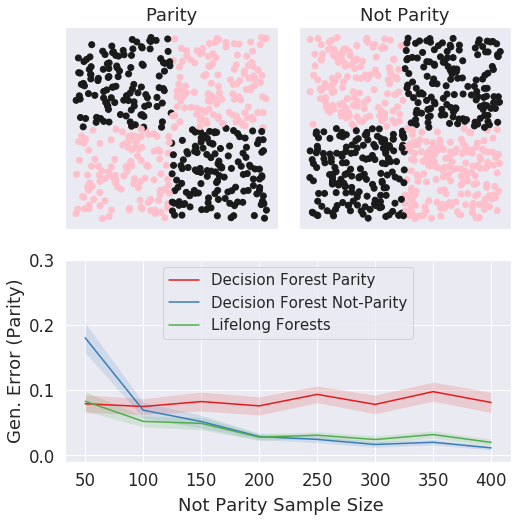

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

gs1 = gridspec.GridSpec(4, 4)
sns.set()

mc_it = mc_its

sns.set(font_scale=1.5)
colors = sns.color_palette("Set1", n_colors = M)

fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(2, 2, 1, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax2 = fig1.add_subplot(2, 2, 2, xticklabels=[], yticklabels=[], xticks=[], yticks=[])

ax1.scatter(X[:, 0], X[:, 1], c = temp_labelsX)
ax2.scatter(Z[:, 0], Z[:, 1], c = temp_labelsZ)

ax1.set_title('Parity')
ax2.set_title('Not Parity')

ax3 = fig1.add_subplot(2,1,2)
# ax3.scatter(Z[:, 0], Z[:, 1], c = temp_labelsZ)
    
# algo_offset=0
# for i, algo in enumerate(algorithms[:3]):
#     ax3.plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i])
#     ax3.fill_between(ns, 
#             mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
#             mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
#             where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
#             facecolor=colors[i], 
#             alpha=0.15,
#             interpolate=True)
# ax3.set_ylabel('Gen. Error (Parity)')
    
algo_offset=3
for i, algo in enumerate(algorithms[algo_offset:algo_offset+3]):
    ax3.plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i + algo_offset])
    ax3.fill_between(ns, 
            mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i +algo_offset], 
            alpha=0.15,
            interpolate=True)
ax3.set_ylabel('Gen. Error (Not Parity)')

# ax[1,0].legend(loc='upper center', fontsize=15)

ax3.legend(loc='upper center', fontsize=15)
ax3.set_ylim(-0.01, 0.3)
# ax[0,1].set_xticks([])
# ax[0,1].set_yticks([])
# ax[1,0].set_title('Backward Transfer')
# ax[1,1].set_title('Forward Transfer')
# # plt.xlabel('Target Task Sample Size')

fig1.subplots_adjust(wspace=0.1, hspace=0.15)

fig1.text(0.5, 0.04, 'Not Parity Sample Size', ha='center')
plt.savefig('L2M_18mo_parity_lifelong.pdf')

In [ ]:
# Figure 1: RF on Parity (single line)

# Figure 2: RF on Not Parity (single line)

# Figure 3: Forward transfer: Get structure of Random Forest using samples from Parity, populate and predict using
# samples from not parity (two lines, not parity forest and parity forest both predicting on not parity)

# Figure 4: Lifelong figure: All three lines for predicting not parity (three lines)

# Figure 5: Reverse transfer

# Figure 6: Lifelong figure

# Repeat figures 1-6 for rotated parity and parity